In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
from pprint import pprint
from sklearn.metrics import roc_curve, auc
from scipy import interp

from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

# Uncomment these lines when you want to calculate SA_Score and SCScore
# sys.path.append('Path_to_/rdkit-master/Contrib/SA_Score')
# sys.path.append('Path_to_/scscore')
# import sascorer
# from scscore.standalone_model_numpy import SCScorer
# scscorer = SCScorer()
# scscorer.restore()

import seaborn as sns
sns.set(font_scale=3)
sns.set_style("ticks")
from mpl_toolkits import mplot3d
# import plotly.express as px
# sns.set_style("whitegrid")

In [2]:
def calc_sa(smi):
    try:
        return sascorer.calculateScore(Chem.MolFromSmiles(smi))
    except:
        return 0

def calc_sc(smi):
    try:
        return scscorer.apply(scscorer.smi_to_fp(smi))
    except:
        return 0
    
def count_plot(df, x1, x2):
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    data = np.zeros([len(x1_candidate), len(x2_candidate)])
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            data[i][j] = len(df[df[x1] == x1_candidate[i]][df[x2] == x2_candidate[j]])
            
    return pd.DataFrame(data, columns=x2_candidate, index=x1_candidate)
    
def normalize(df, axis=1):
    if -1 in df.columns:
        n_sum = np.array(list(df.sum(axis) - df[-1]))
    else:
        n_sum = np.array(list(df.sum(axis)))

    if axis == 1:
        return df / n_sum.reshape(-1, 1)
    elif axis == 0:
        return df / n_sum.reshape(1, -1)
    
def mapping(n):
    if n == 1:
        return 'Synthesizable'
    else:
        return 'Unsynthesizable'
    
def modify(n):
    if n == 1:
        return 1
    else:
        return 0
    
def plot_curve(label, df_temp, start, stop, jump):
    ps = []
    sas = []
    i = start
    gap = jump
    while i < stop:
        sas.append(i)
        temp = df_temp[df_temp[label] > i][df_temp[label] <= i+gap]
        if len(temp) == 0:
            p = 0
        else:
            p = temp.tb_synthesizability.sum() / len(temp)
        ps.append(p)
        i += gap
        
    return sas, ps

def plot_curve_bar(label, df_temp, start, stop, jump):
    ps = []
    sas = []
    count = []
    i = start
    gap = jump
    while i < stop:
        sas.append(i)
        temp = df_temp[df_temp[label] > i][df_temp[label] <= i+gap]
        if len(temp) == 0:
            p = 0
        else:
            p = temp.tb_synthesizability.sum() / len(temp)
        ps.append(p)
#         count.append(len(temp) / len(df_temp))
        count.append(len(temp))
        i += gap
        
    return sas, ps, count

def make_pivot(df, name='property'):
    data = []
    sources = list(set(df.method))
    props = list(set(df.property))
    for source in sources:
        tmp_data = []
        for prop in props:
            tmp_data.append(len(df[df['method'] == source][df['property'] == prop][df['tb_synthesizability'] == 1]) \
                            / len(df[df['method'] == source][df['property'] == prop]))
        data.append(tmp_data)
        
    df_temp = pd.DataFrame(np.array(data), index=sources, columns=props)
    df_temp.index.name = 'method'
    df_temp.columns.name = name
    return df_temp

def calc_avg(df, threshold, x1, x2):
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    data = np.zeros([len(x1_candidate), len(x2_candidate)])
    df_temp = df[df['rank'] <= threshold]
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            tmp = df_temp[df_temp[x1] == x1_candidate[i]][df_temp[x2] == x2_candidate[j]]
            if len(tmp) == threshold:
                data[i][j] = tmp.objective.mean()
            else:
                data[i][j] = np.nan
            
    return pd.DataFrame(data, columns=x2_candidate, index=x1_candidate)

def make_synth_data(df, x1='property', x2='method'):
    df_synth = df[df['tb_synthesizability'] == 1]
    x1_candidate = list(set(df[x1]))
    x2_candidate = list(set(df[x2]))
    dfs = []
    for i in range(len(x1_candidate)):
        for j in range(len(x2_candidate)):
            df_temp = df_synth[df_synth[x1] == x1_candidate[i]][df_synth[x2] == x2_candidate[j]]
            df_temp['rank'] = list(range(1, len(df_temp) + 1))
            dfs.append(df_temp)
    return pd.concat(dfs)

def make_annot(df1, df2):
    df_temp = df1.copy()
    for i in range(len(df1.index)):
        for j in range(len(df1.columns)):
            df_temp.iloc[i, j] = str(df1.iloc[i, j])[:4] + '/' + str(df2.iloc[i, j])[:4]
    return df_temp

def make_ratio(df1, df2, name='name'):
    df_temp = df1.copy()
    for i in range(len(df1.index)):
        for j in range(len(df1.columns)):
            if not np.isnan(df1.iloc[i, j]) and np.isnan(df2.iloc[i, j]):
                df_temp.iloc[i, j] = 1.2
            elif np.isnan(df1.iloc[i, j]):
                df_temp.iloc[i, j] = 0
            else:
                df_temp.iloc[i, j] = df1.iloc[i, j] / df2.iloc[i, j]
    df_temp.index.name = 'property'
    df_temp.columns.name = name
    return df_temp

# Datasets Analysis

In [3]:
# df_datasets.to_csv('./data/original_dataset.csv', index=False)
# df_datasets['tb_synthesizability'] = df_datasets.tb_synthesizability.apply(mapping)
# df_datasets.to_csv('./data/dataset.csv', index=False)

# df = pd.read_csv('./data/original_dataset.csv')
# df['tb_synthesizability'] = df.tb_synthesizability.apply(modify)
# df.to_csv('./data/dataset_01.csv', index=False)

In [9]:
df_datasets = pd.read_csv('./data/dataset.csv')
df_datasets_01 = pd.read_csv('./data/dataset_01.csv')

In [5]:
df_datasets

SMILES   dataset  \
0                          CN(C)CCCN1c2ccccc2CCc2ccccc12  sheridan   
1                    CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1  sheridan   
2      C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N  sheridan   
3                           Nc1ccc(cc1)S(=O)(=O)Nc1nccs1  sheridan   
4                   CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O  sheridan   
...                                                  ...       ...   
13725                   CC1C2CC(=O)C(CC1=O)C1CC(CC21)C#N       gdb   
13726                      C1CC2C3CC(CN2C1)C1CNC(C3)C=C1       gdb   
13727                    CCC(CC)(N=C1NC(O)=CC(F)=C1F)C#N       gdb   
13728                         CC1=C2SC=C1CCCNC1C=C2NC1=O       gdb   
13729                         CCN1CC(=O)CCCC1C1OC2CCC1O2       gdb   

       len_smiles  mean_complexity  sa_score  sc_score  tb_depth  \
0              29         1.938462  1.933100  3.093000         0   
1              35         1.650000  2.435800  3.471000         0   
2              49         2.055556  2.808600  3.777200         0   
3              28         1.432432  2.031700  2.313300         0   
4              36         2.305556  3.712100  2.521600         0   
...           ...              ...       ...       ...       ...   
13725          32              NaN  5.419321  2.797630        11   
13726          29              NaN  5.597288  3.909670        11   
13727          31              NaN  3.981537  2.938651        11   
13728          26              NaN  5.416453  3.580676        11   
13729          26              NaN  5.052316  3.464176        11   

       tb_plausibility  tb_price tb_synthesizability  
0                  1.0       7.0       Synthesizable  
1                  1.0      24.0       Synthesizable  
2                  1.0      10.0       Synthesizable  
3                  1.0       1.0       Synthesizable  
4                  1.0       8.0       Synthesizable  
...                ...       ...                 ...  
13725              0.0      -1.0     Unsynthesizable  
13726              0.0      -1.0     Unsynthesizable  
13727              0.0      -1.0     Unsynthesizable  
13728              0.0      -1.0     Unsynthesizable  
13729              0.0      -1.0     Unsynthesizable  

[13730 rows x 10 columns]

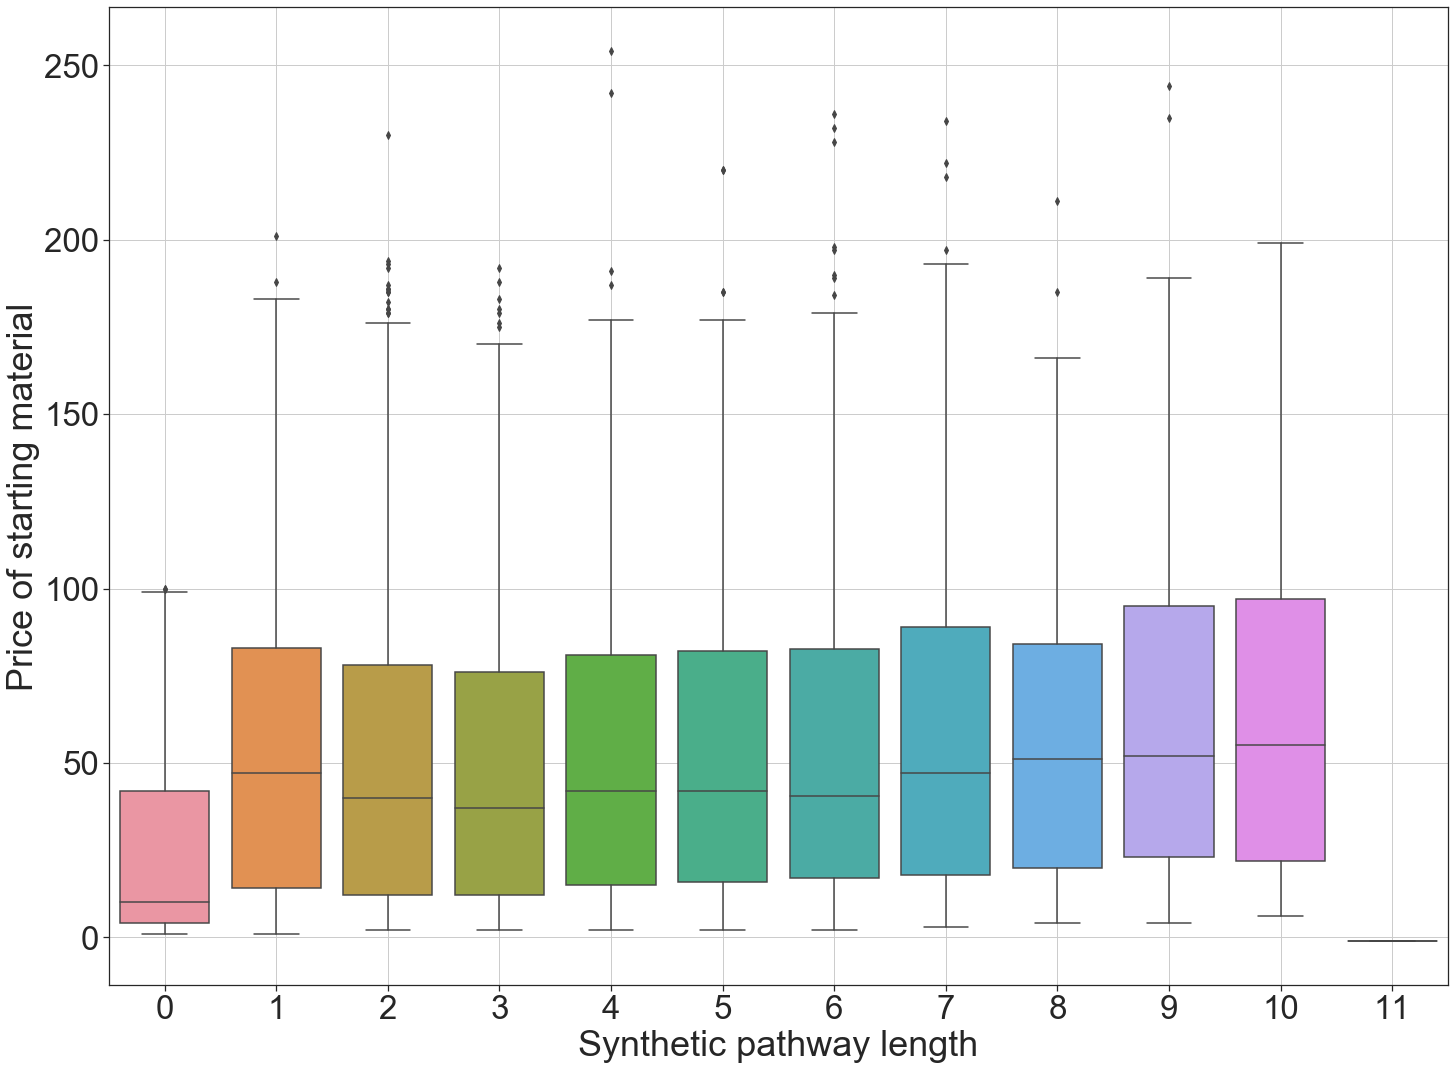

In [7]:
df = df_datasets
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.boxplot(x="tb_depth", y="tb_price", data=df)
ax.set_xlabel('Synthetic pathway length')
ax.set_ylabel('Price of starting material')
plt.grid()
fig.savefig('./figure/all_price_depth.png')

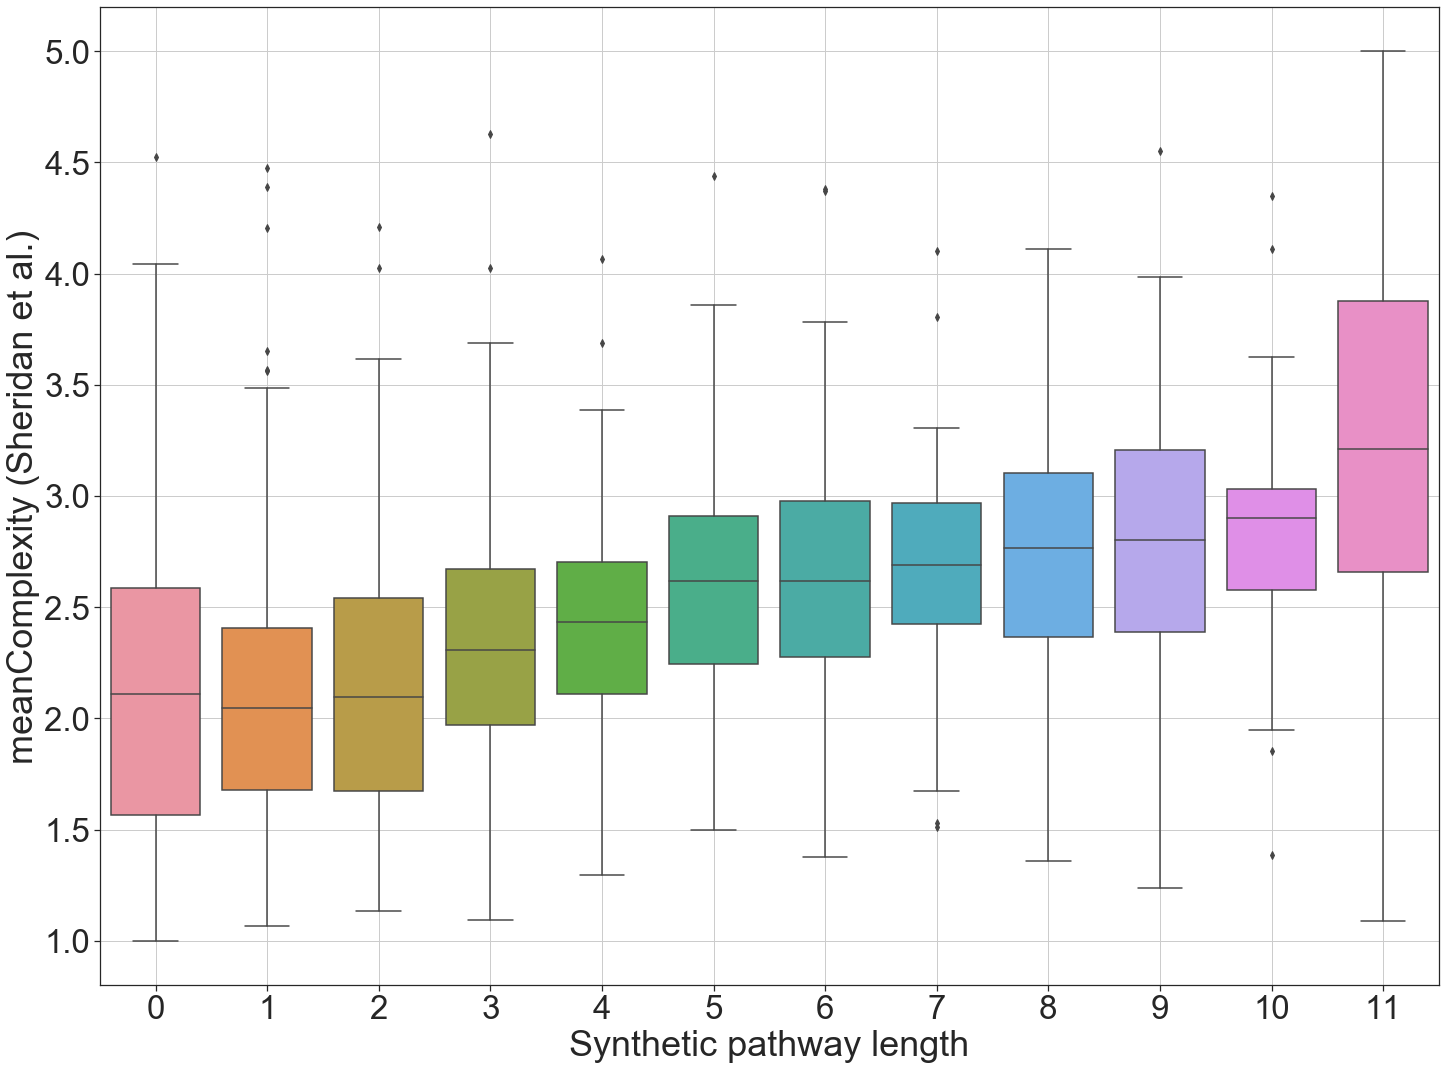

In [85]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.boxplot(x="tb_depth", y="mean_complexity", data=df)
ax.set_xlabel('Synthetic pathway length')
ax.set_ylabel('meanComplexity (Sheridan et al.)')
plt.grid()
fig.savefig('./figure/sheridan_mcomplexity_depth.png')

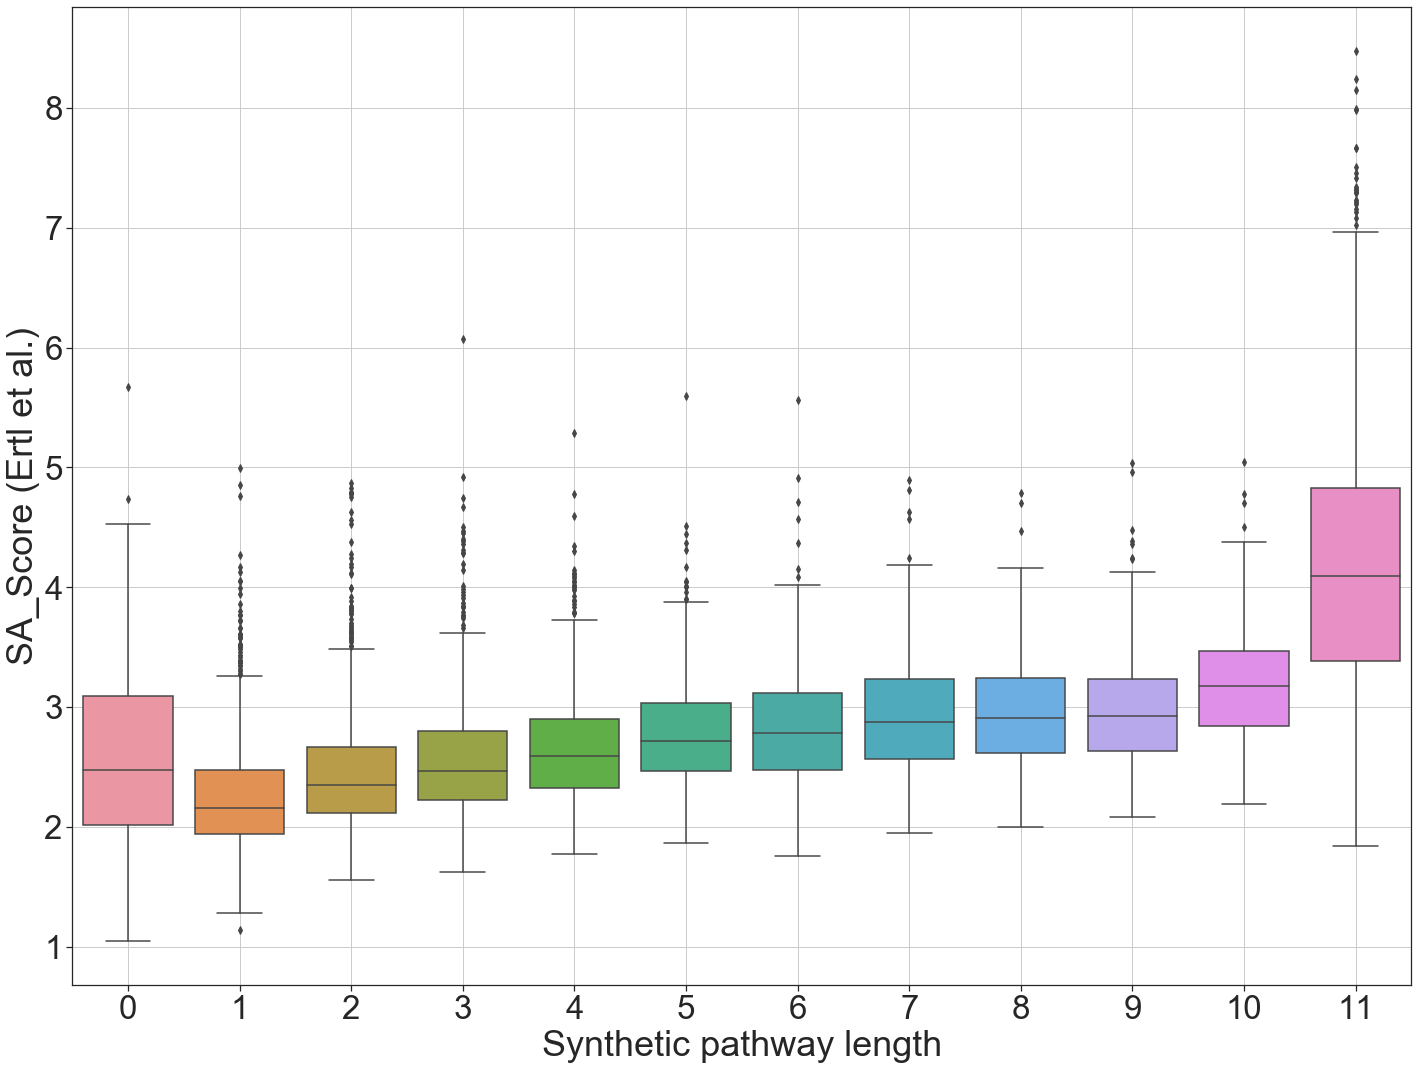

In [86]:
df = df_datasets #[df_datasets['dataset'] == 'sheridan']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.boxplot(x="tb_depth", y="sa_score", data=df)
ax.set_xlabel('Synthetic pathway length')
ax.set_ylabel('SA_Score (Ertl et al.)')
plt.grid()
fig.savefig('./figure/all_sa_depth.png')

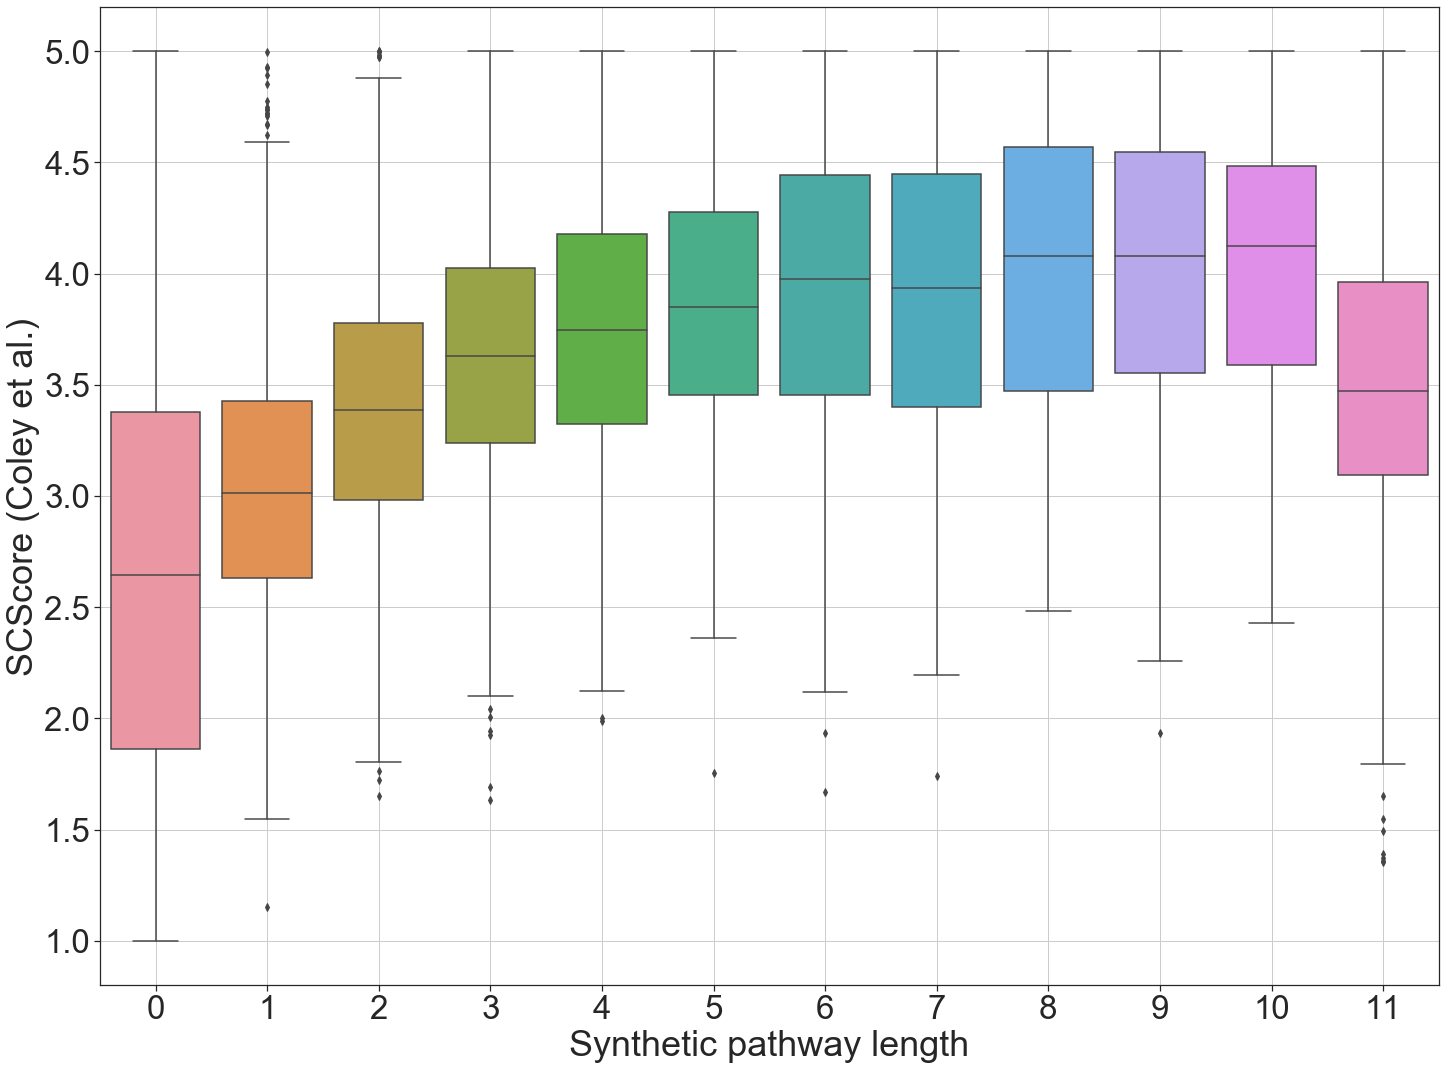

In [87]:
df = df_datasets #[df_datasets['dataset'] == 'sheridan']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.boxplot(x="tb_depth", y="sc_score", data=df)
ax.set_xlabel('Synthetic pathway length')
ax.set_ylabel('SCScore (Coley et al.)')
plt.grid()
fig.savefig('./figure/all_sc_depth.png')

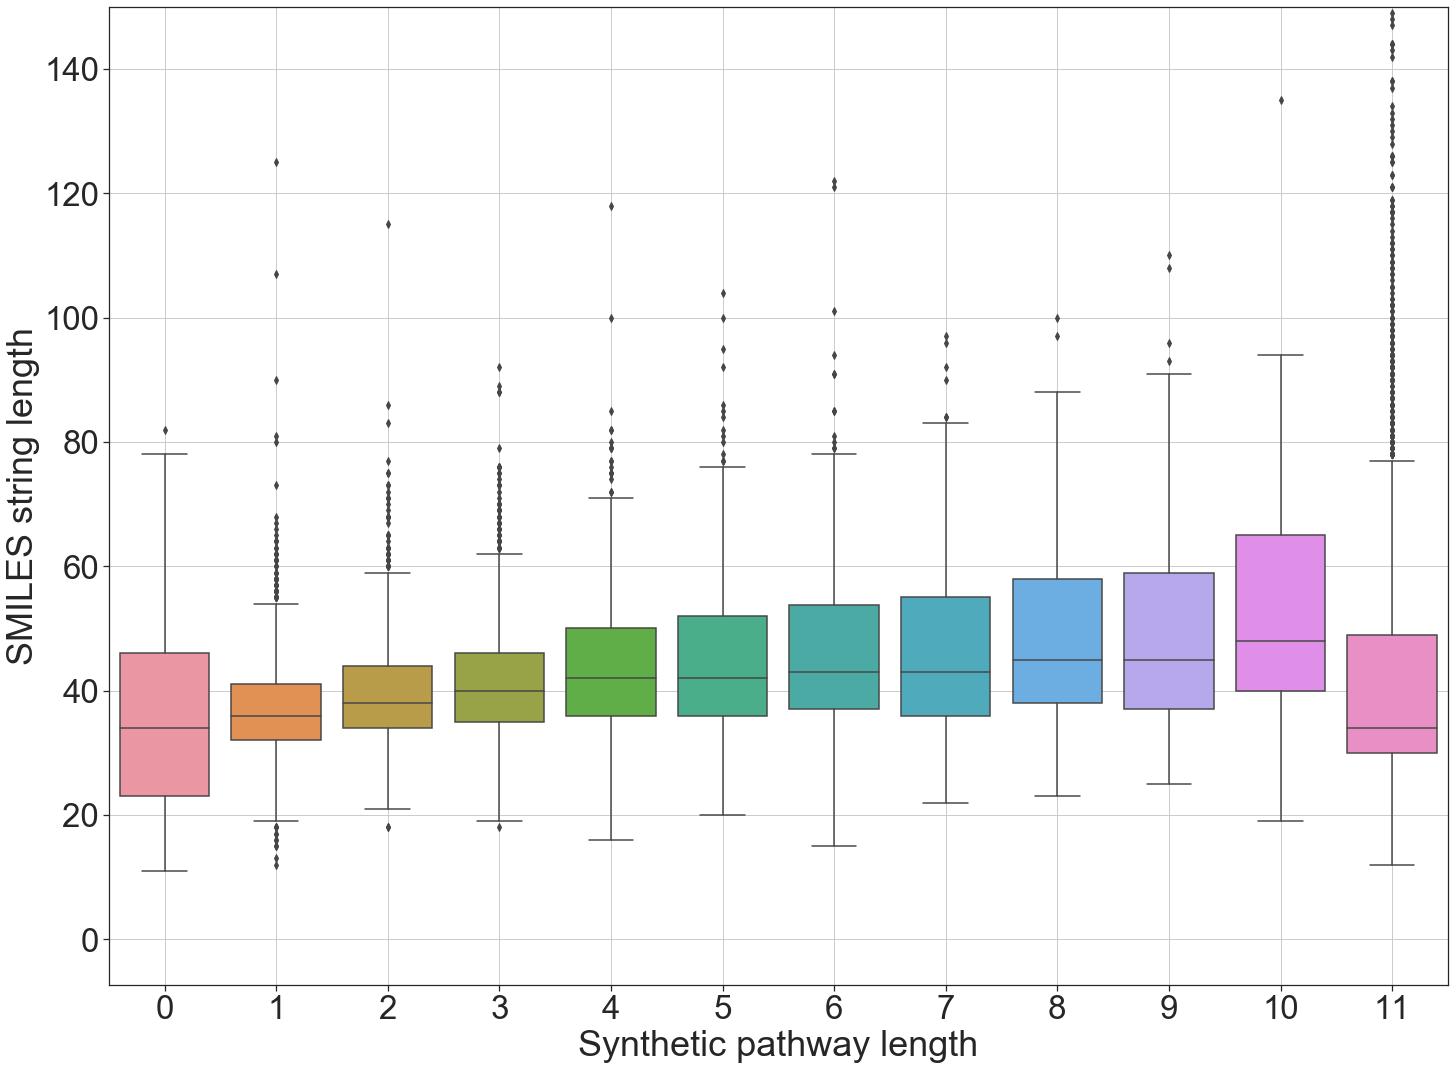

In [91]:
df = df_datasets #[df_datasets['dataset'] == 'sheridan']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.boxplot(x="tb_depth", y="len_smiles", data=df)
ax.set_xlabel('Synthetic pathway length')
ax.set_ylabel('SMILES string length')
ax.set_ylim(top=150)
plt.grid()
fig.savefig('./figure/all_smi_depth.png')

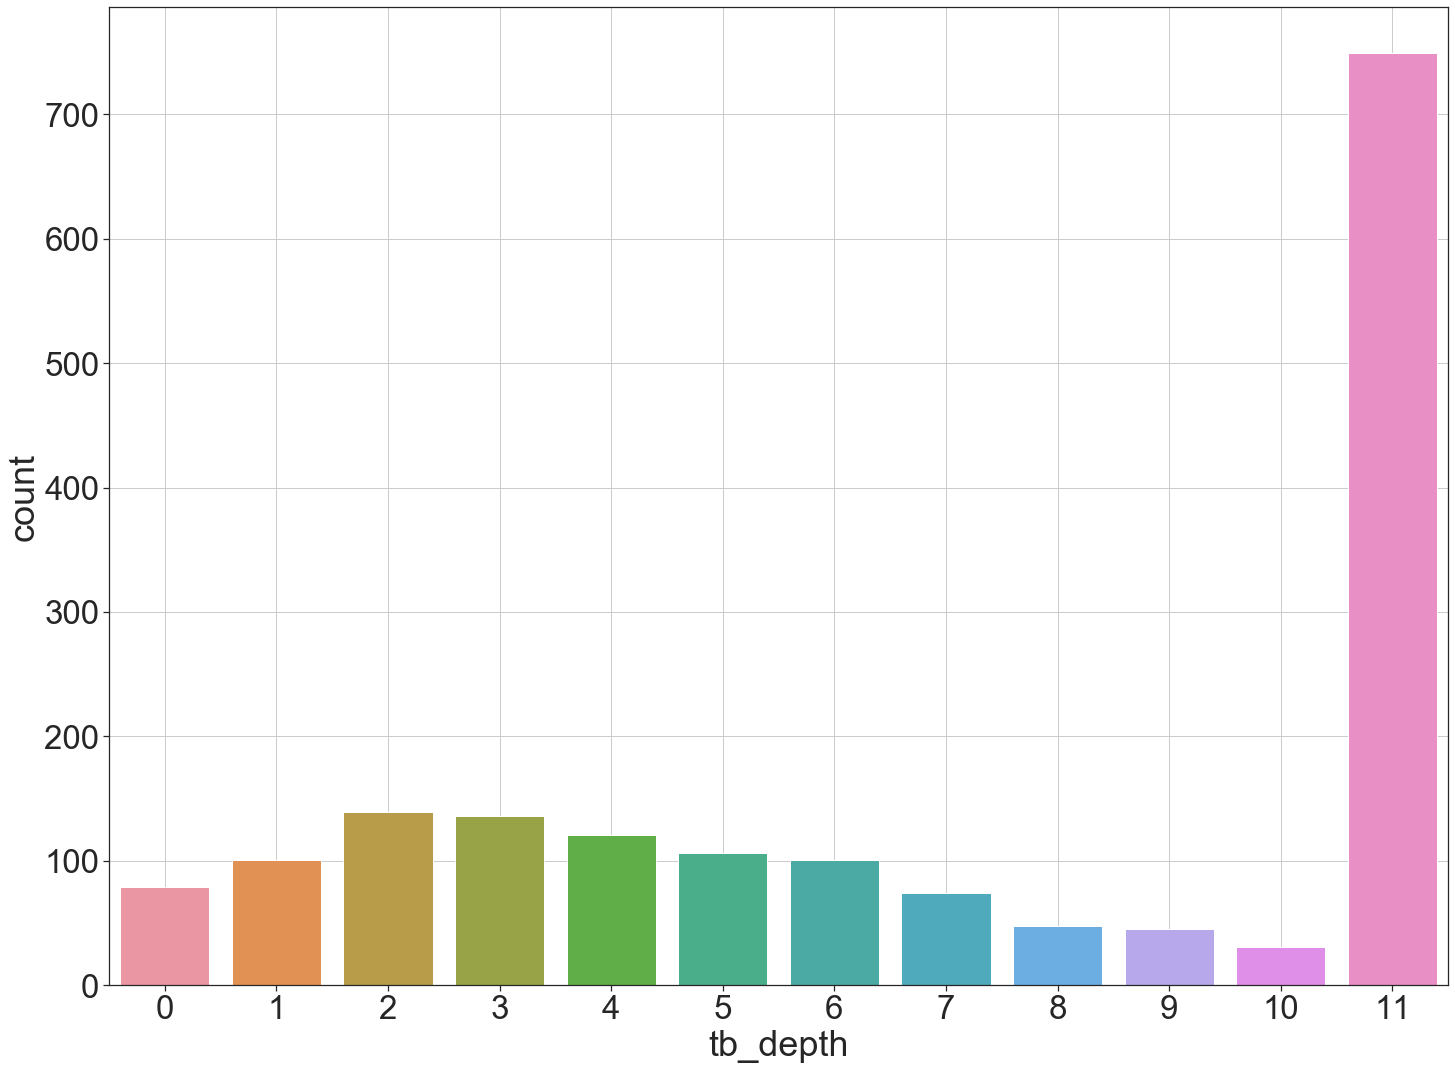

In [93]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df)
ax.grid()
fig.savefig('./figure/sheridan_count.png')

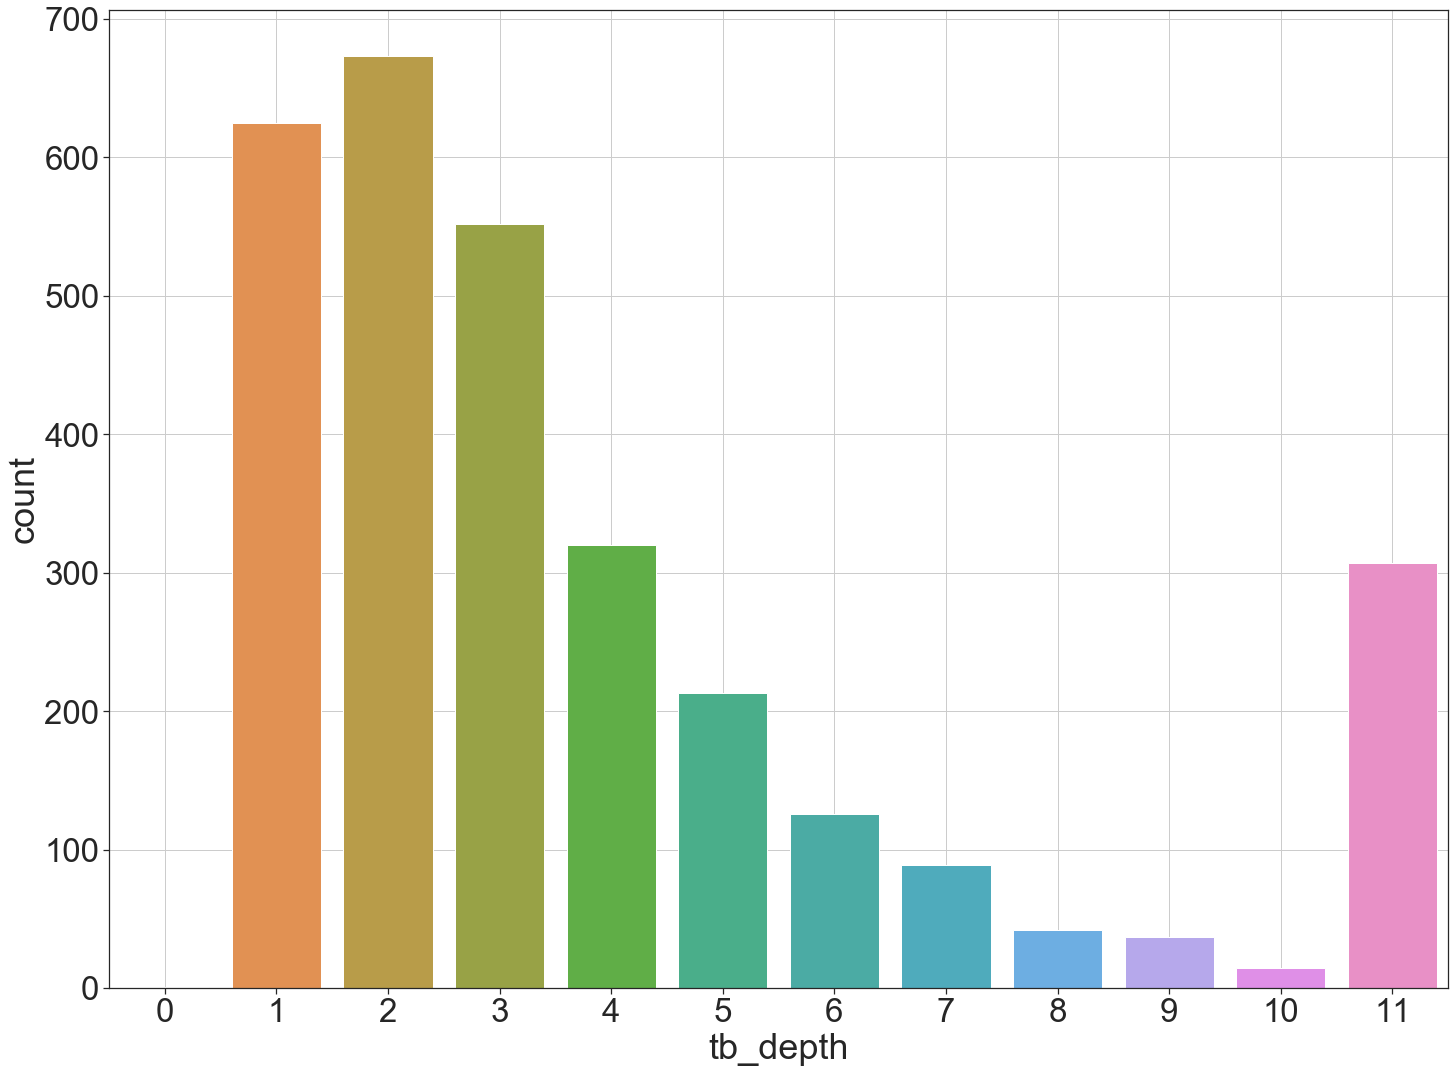

In [94]:
df = df_datasets[df_datasets['dataset'] == 'moses']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df)
ax.grid()
fig.savefig('./figure/moses_count.png')

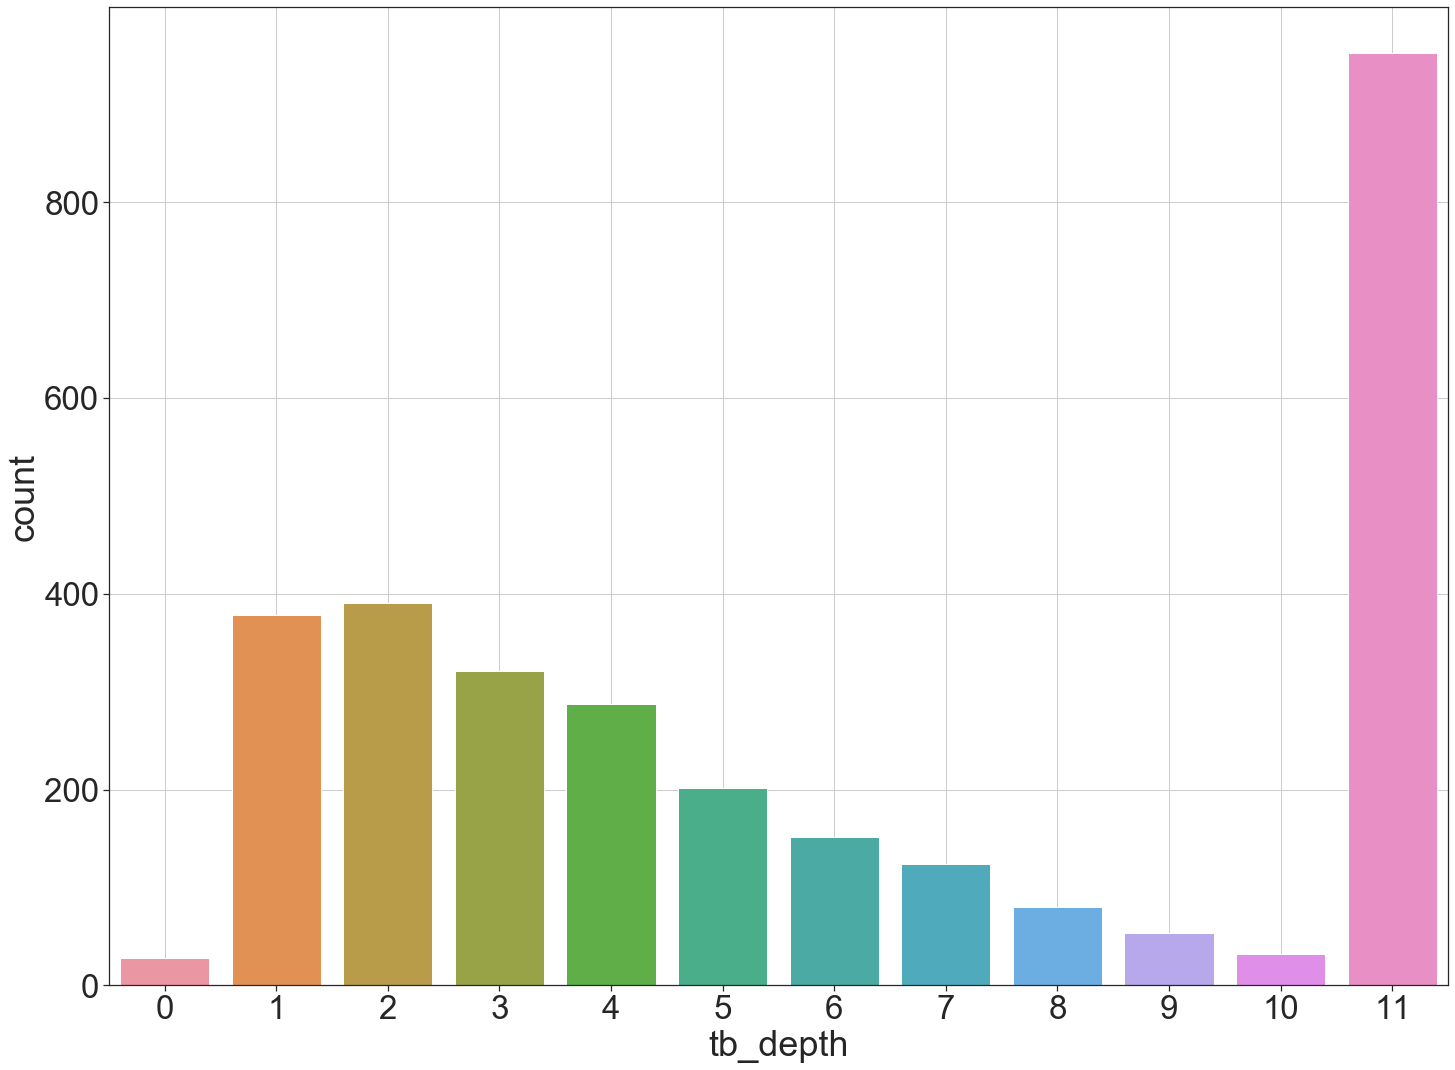

In [95]:
df = df_datasets[df_datasets['dataset'] == 'guacamol']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df)
ax.grid()
fig.savefig('./figure/guacamol_count.png')

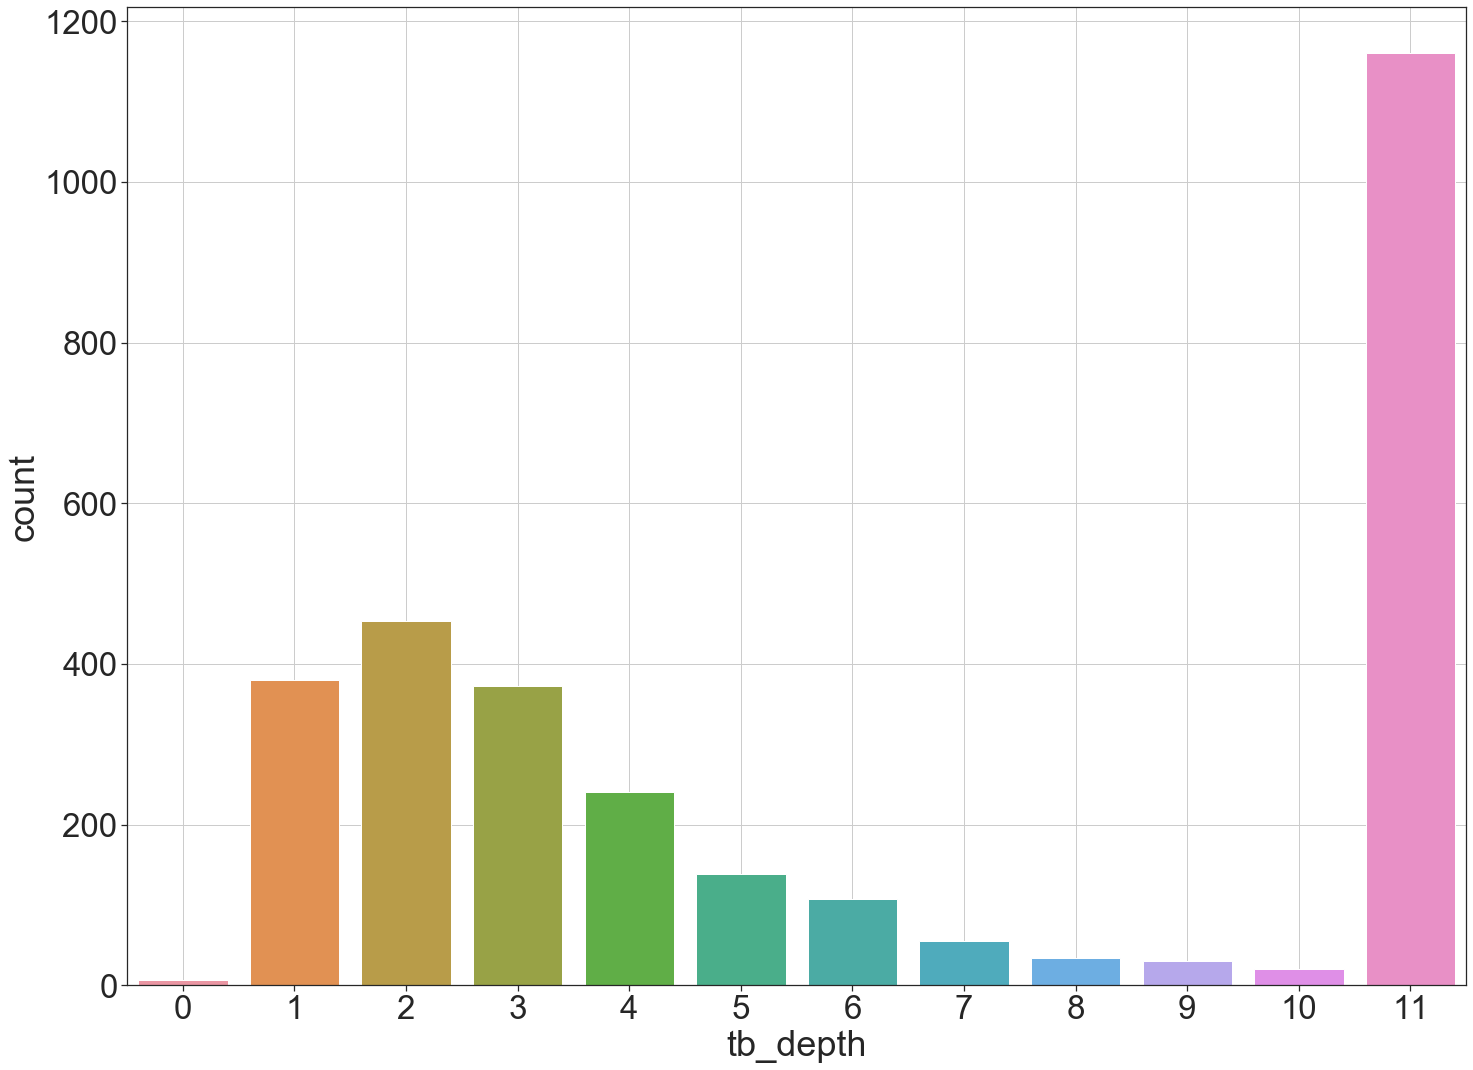

In [96]:
df = df_datasets[df_datasets['dataset'] == 'zinc']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df)
ax.grid()
fig.savefig('./figure/zinc_count.png')

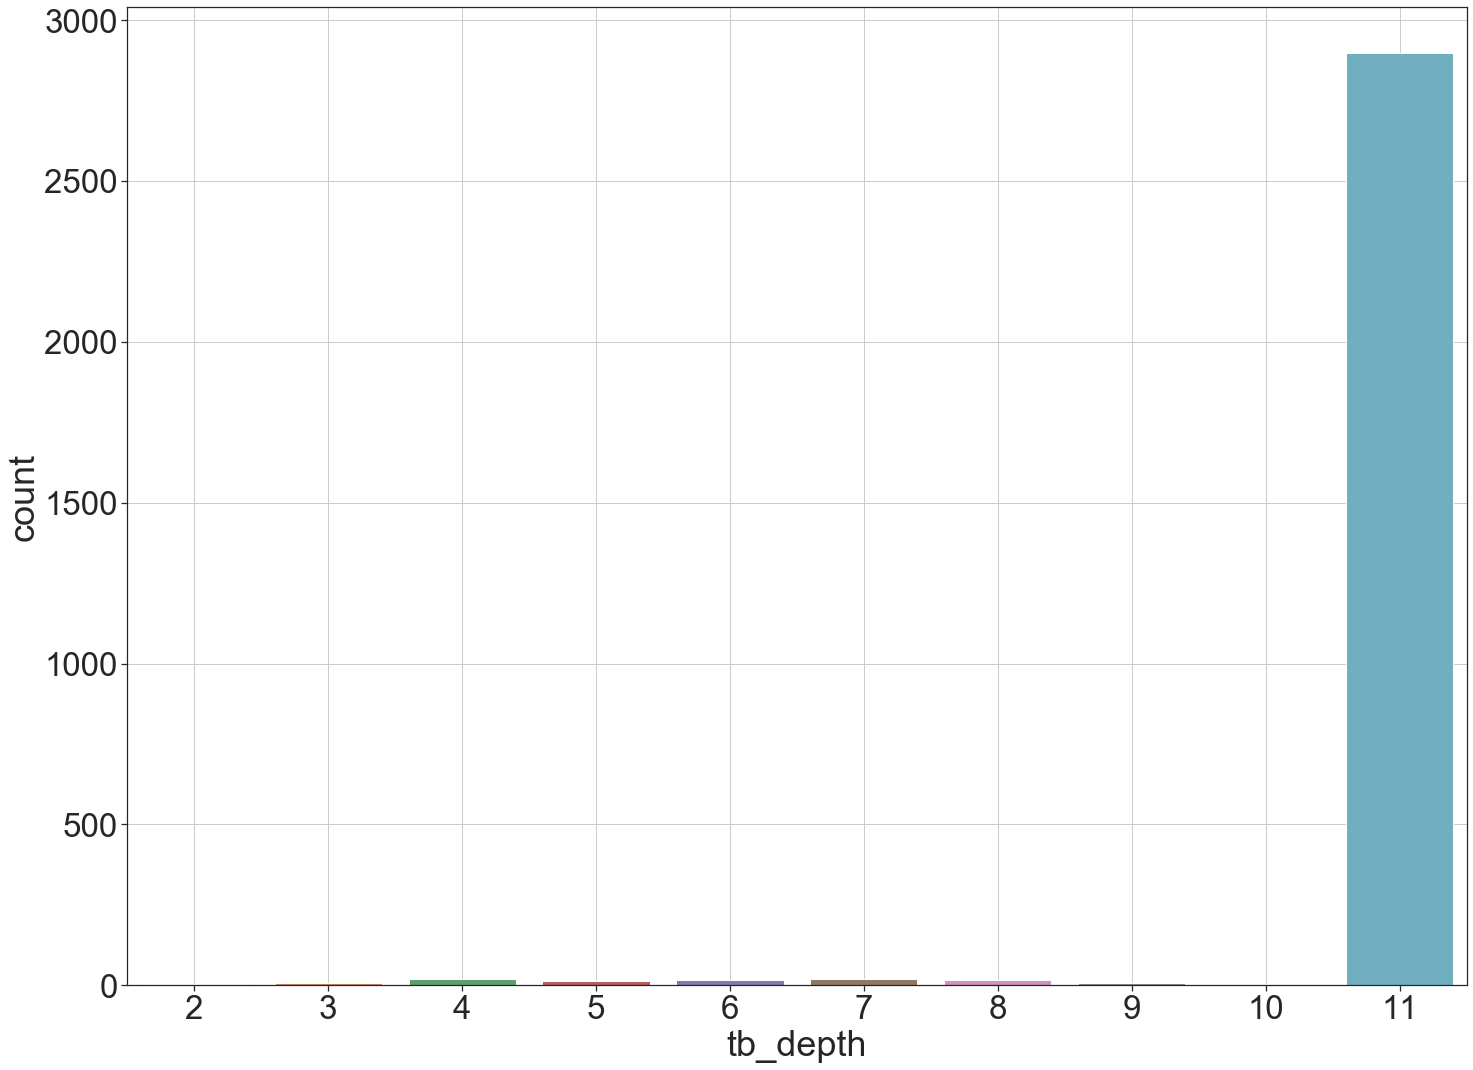

In [97]:
df = df_datasets[df_datasets['dataset'] == 'gdb']
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df)
ax.grid()
fig.savefig('./figure/gdb_count.png')

In [84]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
df = df.rename(columns={
    'mean_complexity': 'meanComplexity (Sheridan et al.)',
    'tb_depth': 'Synthetic pathway length',
    'tb_synthesizability': 'Synthesizability',
    'tb_price': 'Price of starting material',
    'tb_plausibility': 'Plausibility',
    'sa_score': 'SA_Score (Ertl et al.)',
    'sc_score': 'SCScore (Coley et al.)',
    'len_smiles': 'SMILES string length'
})

SMILES   dataset  \
0                         CN(C)CCCN1c2ccccc2CCc2ccccc12  sheridan   
1                   CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1  sheridan   
2     C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N  sheridan   
3                          Nc1ccc(cc1)S(=O)(=O)Nc1nccs1  sheridan   
4                  CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O  sheridan   
...                                                 ...       ...   
1725  C1[C@@]2(OC[C@]1(C)OC)C=C([C@@H]1CC[C@@]34[C@@...  sheridan   
1726  c1(c(c(O)ccc1OC)O)C[C@@]1(C=2CCCC(C2CC[C@@H]1C...  sheridan   
1727  C1CC(C)(C)[C@@H]2CCC([C@@H](\C=C3\C=C4C(=CC3=O...  sheridan   
1728      CC(C)(C)NC[C@@H](CSc1nc(cs1)c1ccc(C(N)=O)s1)O  sheridan   
1729      CCOC(=O)C(=O)Nc1cc(cc(c1Cl)NC(=O)C(=O)OCC)C#N  sheridan   

      SMILES string length  meanComplexity (Sheridan et al.)  \
0                       29                          1.938462   
1                       35                          1.650000   
2                       49                          2.055556   
3                       28                          1.432432   
4                       36                          2.305556   
...                    ...                               ...   
1725                   144                          4.944444   
1726                    53                          3.472222   
1727                    66                          3.704545   
1728                    45                          2.574074   
1729                    45                          2.222222   

      SA_Score (Ertl et al.)  SCScore (Coley et al.)  \
0                     1.9331                  3.0930   
1                     2.4358                  3.4710   
2                     2.8086                  3.7772   
3                     2.0317                  2.3133   
4                     3.7121                  2.5216   
...                      ...                     ...   
1725                  6.3422                  3.8980   
1726                  3.9093                  4.0573   
1727                  4.5864                  4.0433   
1728                  3.2400                  3.6808   
1729                  2.5960                  2.3712   

      Synthetic pathway length  Plausibility  Price of starting material  \
0                            0      1.000000                         7.0   
1                            0      1.000000                        24.0   
2                            0      1.000000                        10.0   
3                            0      1.000000                         1.0   
4                            0      1.000000                         8.0   
...                        ...           ...                         ...   
1725                        11      0.000000                        -1.0   
1726                        11      0.000000                        -1.0   
1727                        11      0.000000                        -1.0   
1728                         0      1.000000                        84.0   
1729                         6      0.047843                         3.0   

     Synthesizability  
0       Synthesizable  
1       Synthesizable  
2       Synthesizable  
3       Synthesizable  
4       Synthesizable  
...               ...  
1725  Unsynthesizable  
1726  Unsynthesizable  
1727  Unsynthesizable  
1728    Synthesizable  
1729    Synthesizable  

[1730 rows x 10 columns]

<Figure size 1728x1296 with 0 Axes>

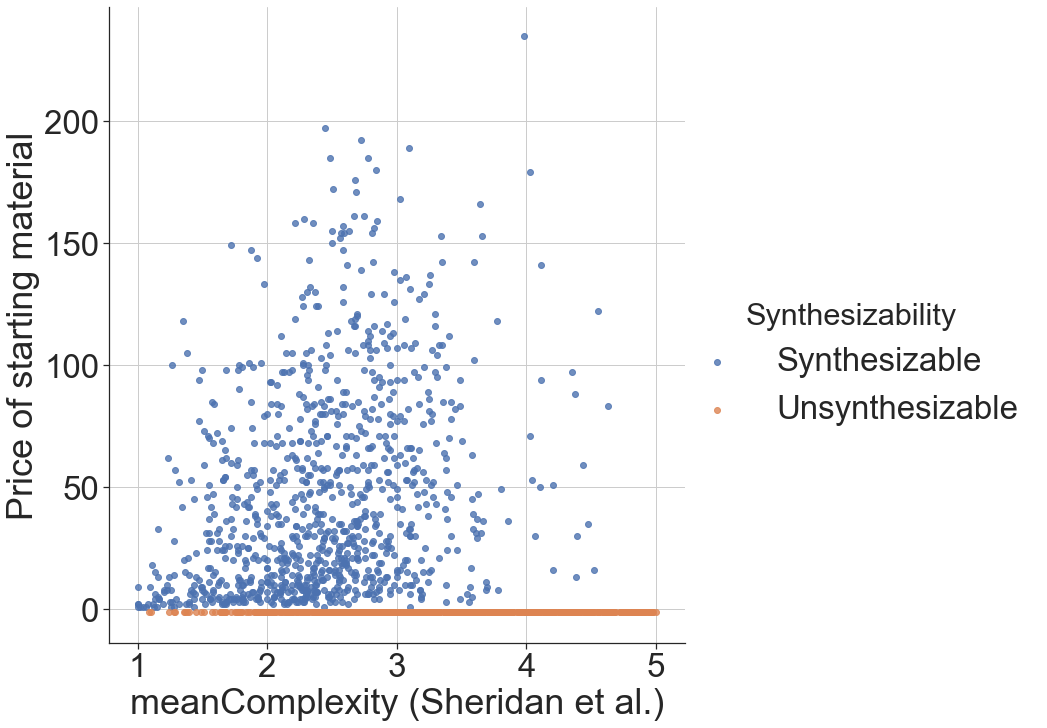

In [88]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
df = df.rename(columns={
    'mean_complexity': 'meanComplexity (Sheridan et al.)',
    'tb_depth': 'Synthetic pathway length',
    'tb_synthesizability': 'Synthesizability',
    'tb_price': 'Price of starting material',
    'tb_plausibility': 'Plausibility',
    'sa_score': 'SA_Score (Ertl et al.)',
    'sc_score': 'SCScore (Coley et al.)',
    'len_smiles': 'SMILES string length'
})
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=1.5)
g = sns.lmplot(x="meanComplexity (Sheridan et al.)", y="Price of starting material", data=df, fit_reg=False,hue='Synthesizability',scatter=True, size=11)
# g = sns.jointplot(x="mean_complexity", y="tb_price", hue="tb_synthesizability", data=df, size=11)
plt.grid()
g.savefig('./figure/sheridan_price_mcomplexity.png')

<Figure size 1728x1296 with 0 Axes>

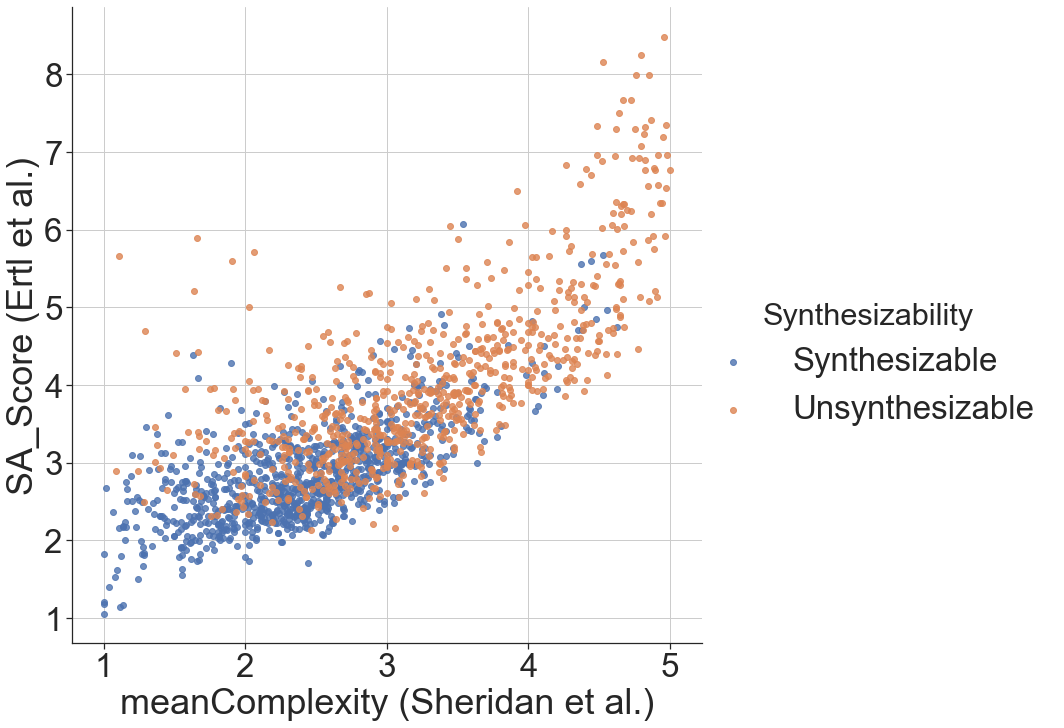

In [89]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
df = df.rename(columns={
    'mean_complexity': 'meanComplexity (Sheridan et al.)',
    'tb_depth': 'Synthetic pathway length',
    'tb_synthesizability': 'Synthesizability',
    'tb_price': 'Price of starting material',
    'tb_plausibility': 'Plausibility',
    'sa_score': 'SA_Score (Ertl et al.)',
    'sc_score': 'SCScore (Coley et al.)',
    'len_smiles': 'SMILES string length'
})
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=1.5)
g = sns.lmplot(x="meanComplexity (Sheridan et al.)", y="SA_Score (Ertl et al.)", data=df, fit_reg=False,hue='Synthesizability',scatter=True, size=11)
plt.grid()
g.savefig('./figure/sheridan_sa_mcomplexity.png')

<Figure size 1728x1296 with 0 Axes>

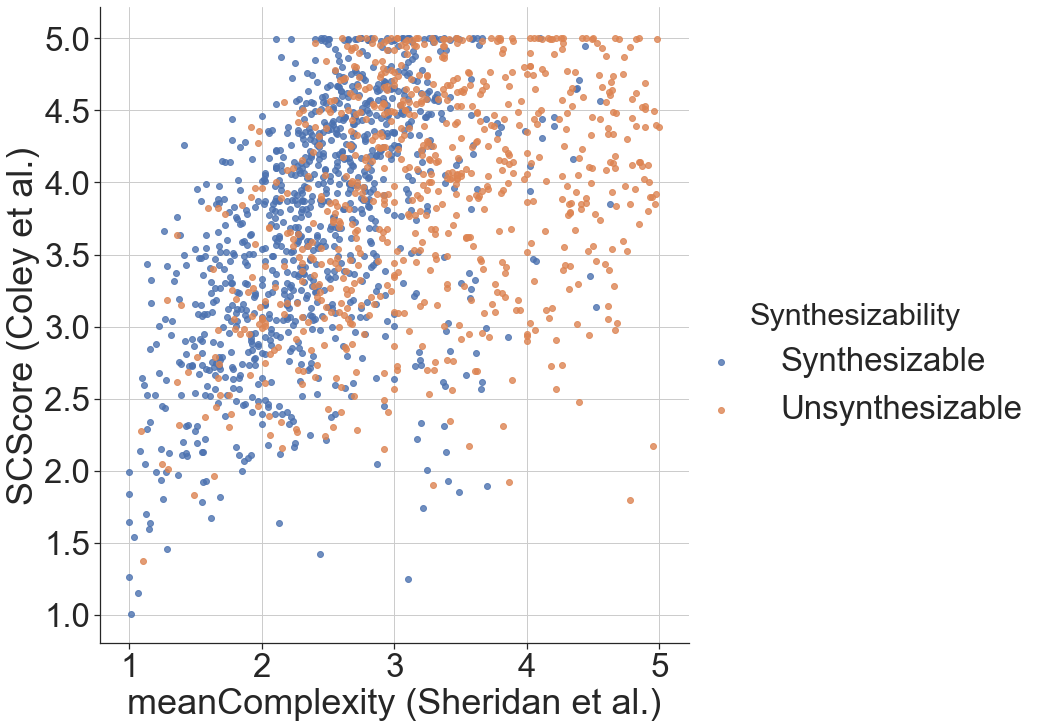

In [90]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
df = df.rename(columns={
    'mean_complexity': 'meanComplexity (Sheridan et al.)',
    'tb_depth': 'Synthetic pathway length',
    'tb_synthesizability': 'Synthesizability',
    'tb_price': 'Price of starting material',
    'tb_plausibility': 'Plausibility',
    'sa_score': 'SA_Score (Ertl et al.)',
    'sc_score': 'SCScore (Coley et al.)',
    'len_smiles': 'SMILES string length'
})
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=1.5)
g = sns.lmplot(x="meanComplexity (Sheridan et al.)", y="SCScore (Coley et al.)", data=df, fit_reg=False,hue='Synthesizability',scatter=True, size=11)
plt.grid()
g.savefig('./figure/sheridan_sc_mcomplexity.png')

<Figure size 1728x1296 with 0 Axes>

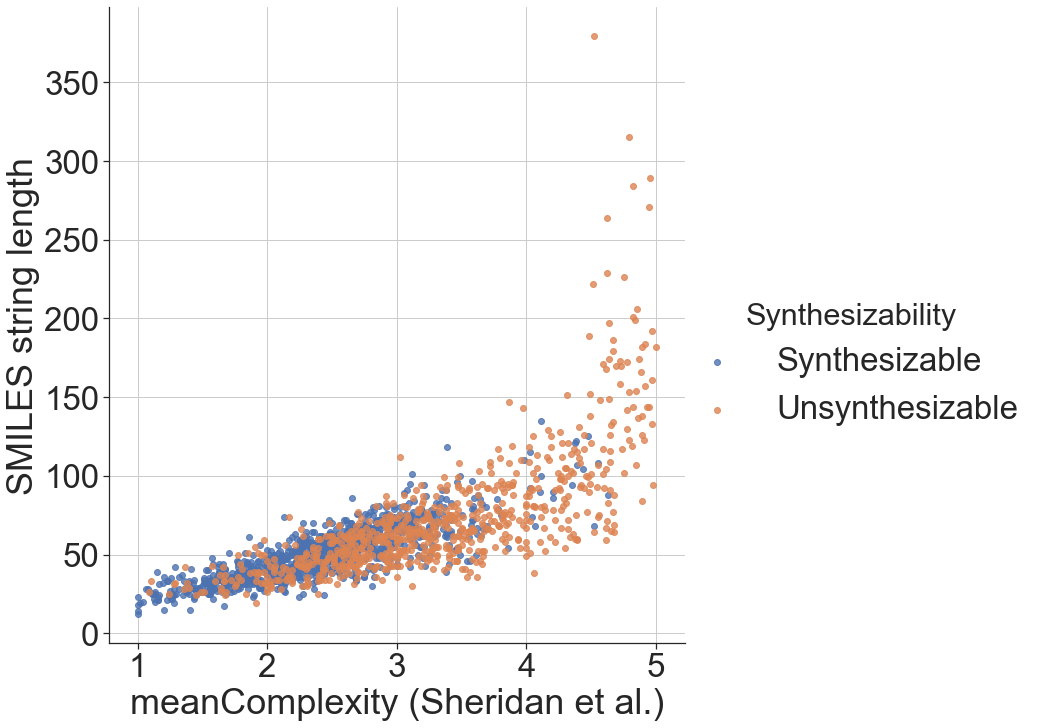

In [91]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
df = df.rename(columns={
    'mean_complexity': 'meanComplexity (Sheridan et al.)',
    'tb_depth': 'Synthetic pathway length',
    'tb_synthesizability': 'Synthesizability',
    'tb_price': 'Price of starting material',
    'tb_plausibility': 'Plausibility',
    'sa_score': 'SA_Score (Ertl et al.)',
    'sc_score': 'SCScore (Coley et al.)',
    'len_smiles': 'SMILES string length'
})
fig = plt.figure(figsize=[24, 18])
# sns.set(font_scale=1.5)
g = sns.lmplot(x="meanComplexity (Sheridan et al.)", y="SMILES string length", data=df, fit_reg=False,hue='Synthesizability',scatter=True, size=11)
plt.grid()
g.savefig('./figure/sheridan_smi_mcomplexity.png')

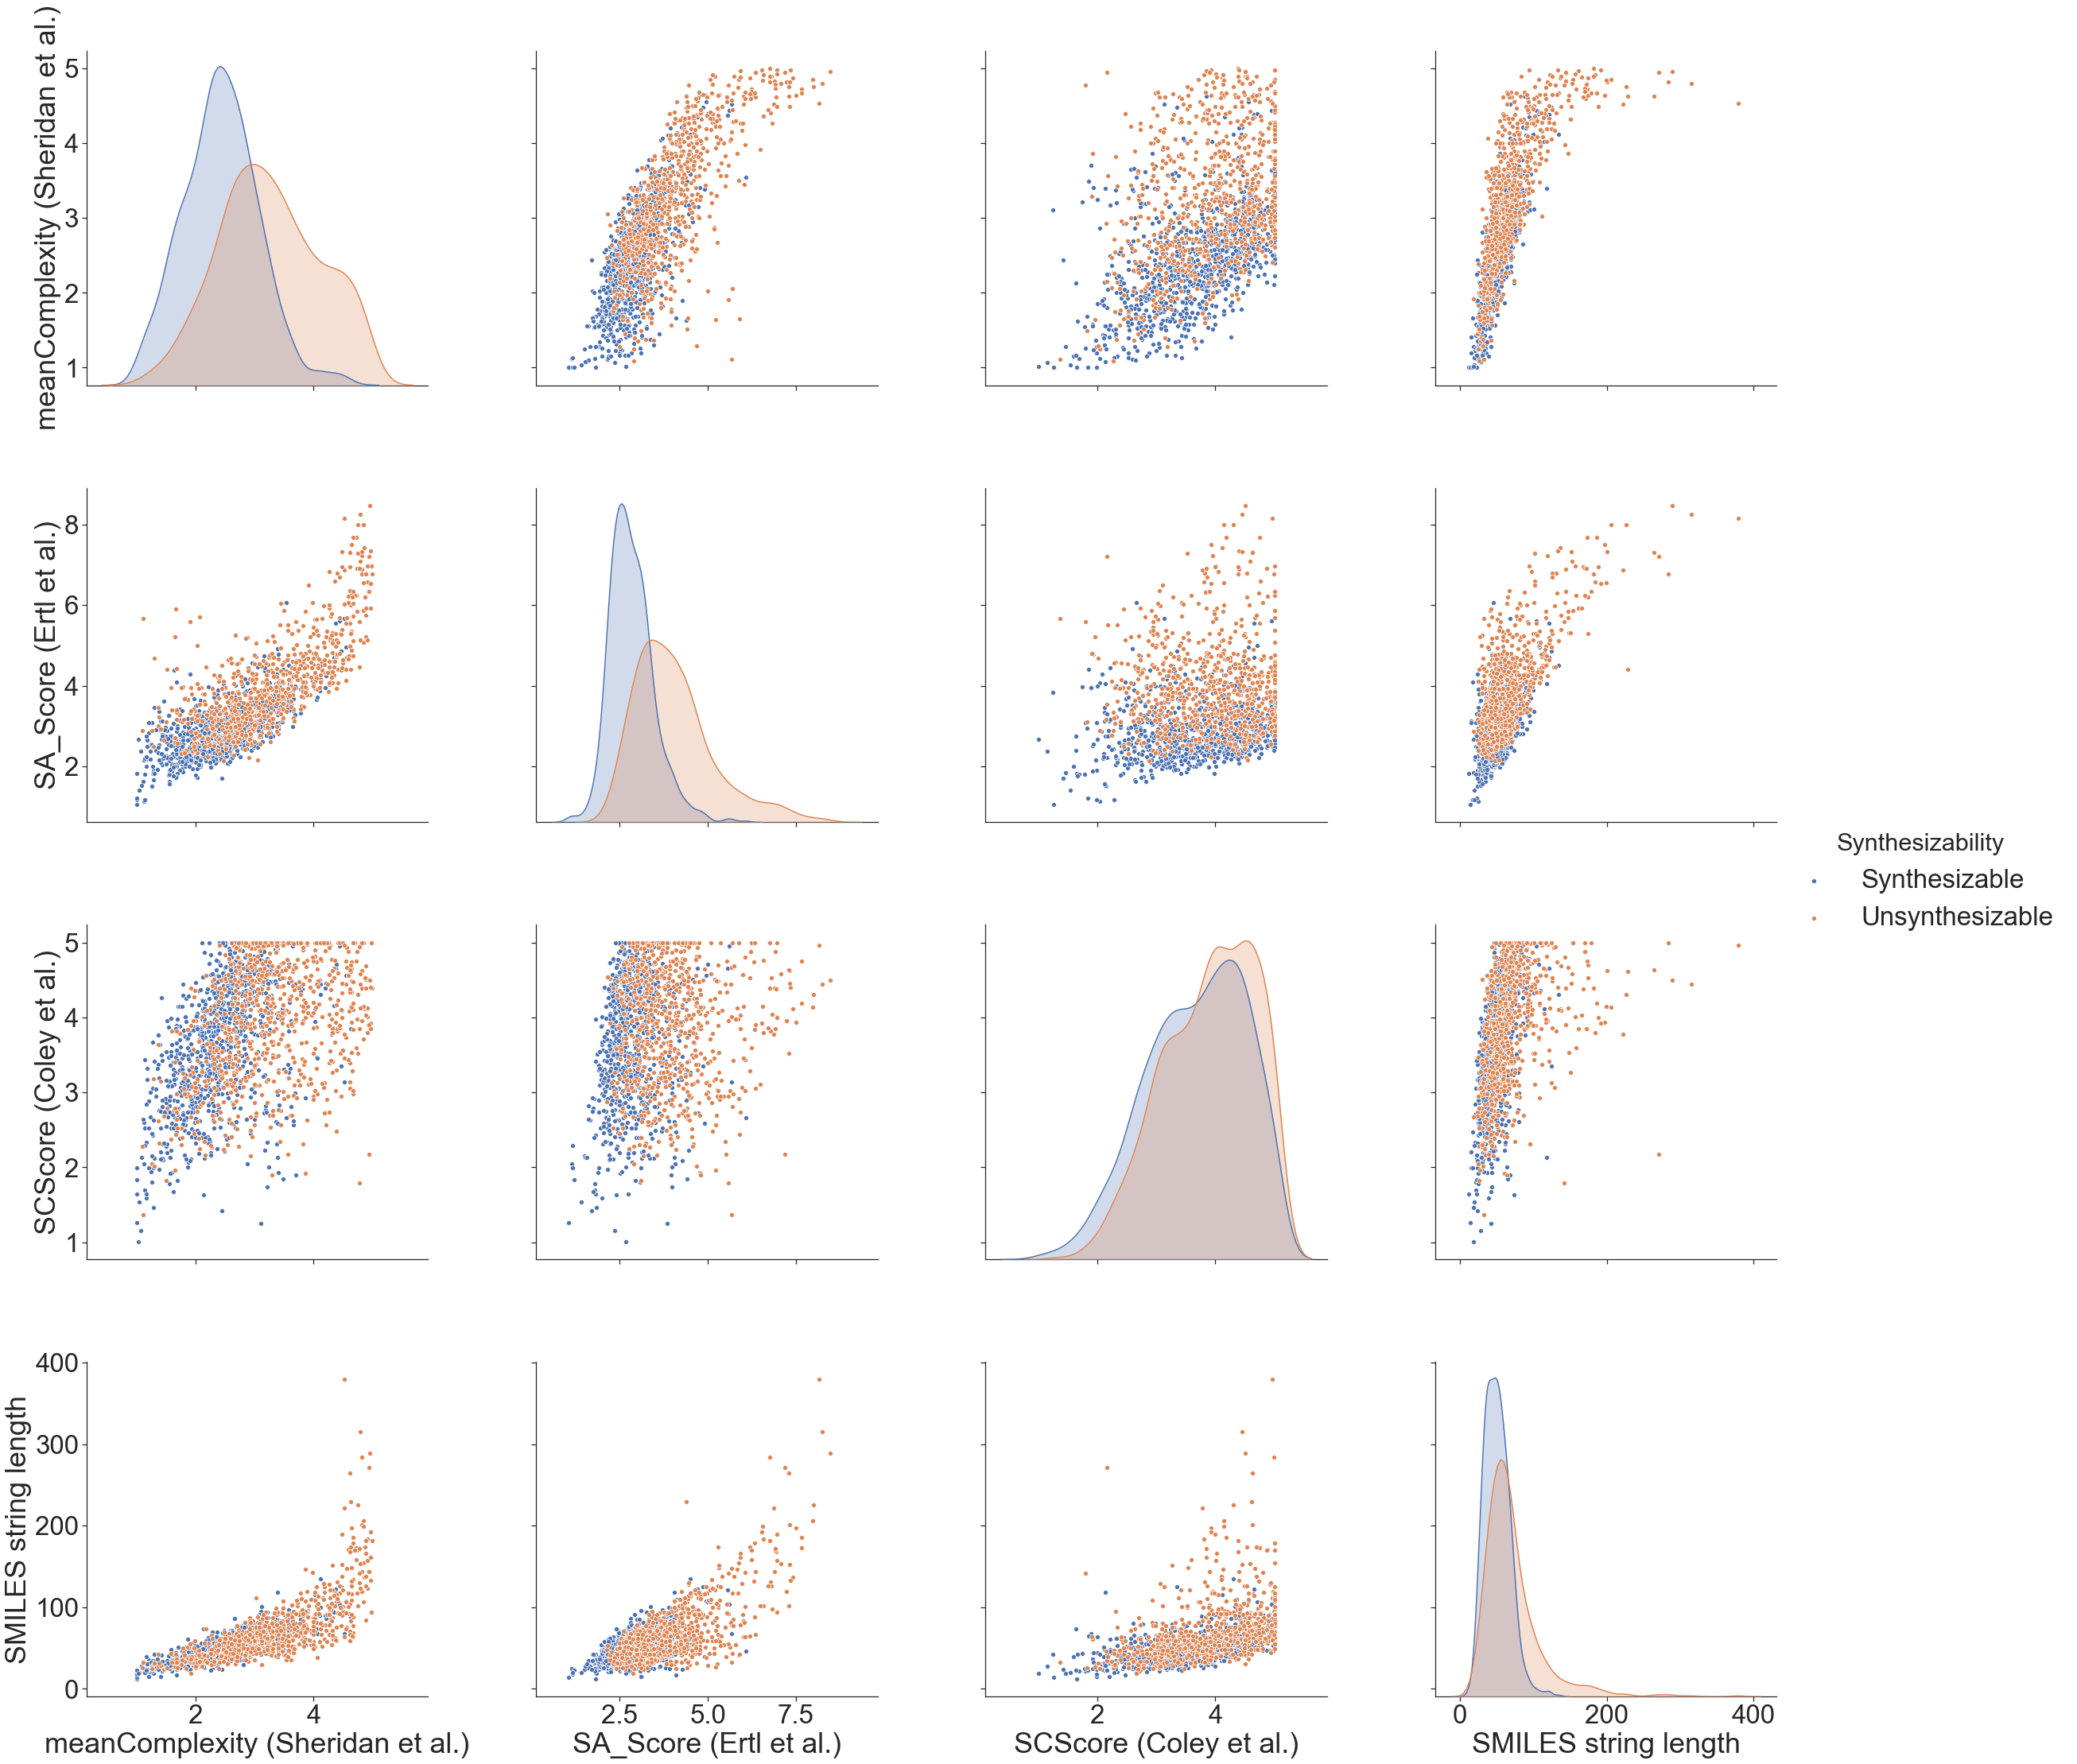

In [93]:
df = df_datasets[df_datasets['dataset'] == 'sheridan']
df = df.rename(columns={
    'mean_complexity': 'meanComplexity (Sheridan et al.)',
    'tb_depth': 'Synthetic pathway length',
    'tb_synthesizability': 'Synthesizability',
    'tb_price': 'Price of starting material',
    'tb_plausibility': 'Plausibility',
    'sa_score': 'SA_Score (Ertl et al.)',
    'sc_score': 'SCScore (Coley et al.)',
    'len_smiles': 'SMILES string length'
})
# sns.set(font_scale=3)
g = sns.pairplot(df, hue="Synthesizability", vars=["meanComplexity (Sheridan et al.)", "SA_Score (Ertl et al.)", "SCScore (Coley et al.)", "SMILES string length"], size=8)
g.savefig('./figure/sheridan_pplot.png')

In [37]:
df_datasets_01

SMILES   dataset  \
0                          CN(C)CCCN1c2ccccc2CCc2ccccc12  sheridan   
1                    CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1  sheridan   
2      C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N  sheridan   
3                           Nc1ccc(cc1)S(=O)(=O)Nc1nccs1  sheridan   
4                   CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O  sheridan   
...                                                  ...       ...   
13725                   CC1C2CC(=O)C(CC1=O)C1CC(CC21)C#N       gdb   
13726                      C1CC2C3CC(CN2C1)C1CNC(C3)C=C1       gdb   
13727                    CCC(CC)(N=C1NC(O)=CC(F)=C1F)C#N       gdb   
13728                         CC1=C2SC=C1CCCNC1C=C2NC1=O       gdb   
13729                         CCN1CC(=O)CCCC1C1OC2CCC1O2       gdb   

       len_smiles  mean_complexity  sa_score  sc_score  tb_depth  \
0              29         1.938462  1.933100  3.093000         0   
1              35         1.650000  2.435800  3.471000         0   
2              49         2.055556  2.808600  3.777200         0   
3              28         1.432432  2.031700  2.313300         0   
4              36         2.305556  3.712100  2.521600         0   
...           ...              ...       ...       ...       ...   
13725          32              NaN  5.419321  2.797630        11   
13726          29              NaN  5.597288  3.909670        11   
13727          31              NaN  3.981537  2.938651        11   
13728          26              NaN  5.416453  3.580676        11   
13729          26              NaN  5.052316  3.464176        11   

       tb_plausibility  tb_price  tb_synthesizability  
0                  1.0       7.0                    1  
1                  1.0      24.0                    1  
2                  1.0      10.0                    1  
3                  1.0       1.0                    1  
4                  1.0       8.0                    1  
...                ...       ...                  ...  
13725              0.0      -1.0                    0  
13726              0.0      -1.0                    0  
13727              0.0      -1.0                    0  
13728              0.0      -1.0                    0  
13729              0.0      -1.0                    0  

[13730 rows x 10 columns]

FileNotFoundError: [Errno 2] No such file or directory: './figure/heuristic_roc_curve.png'

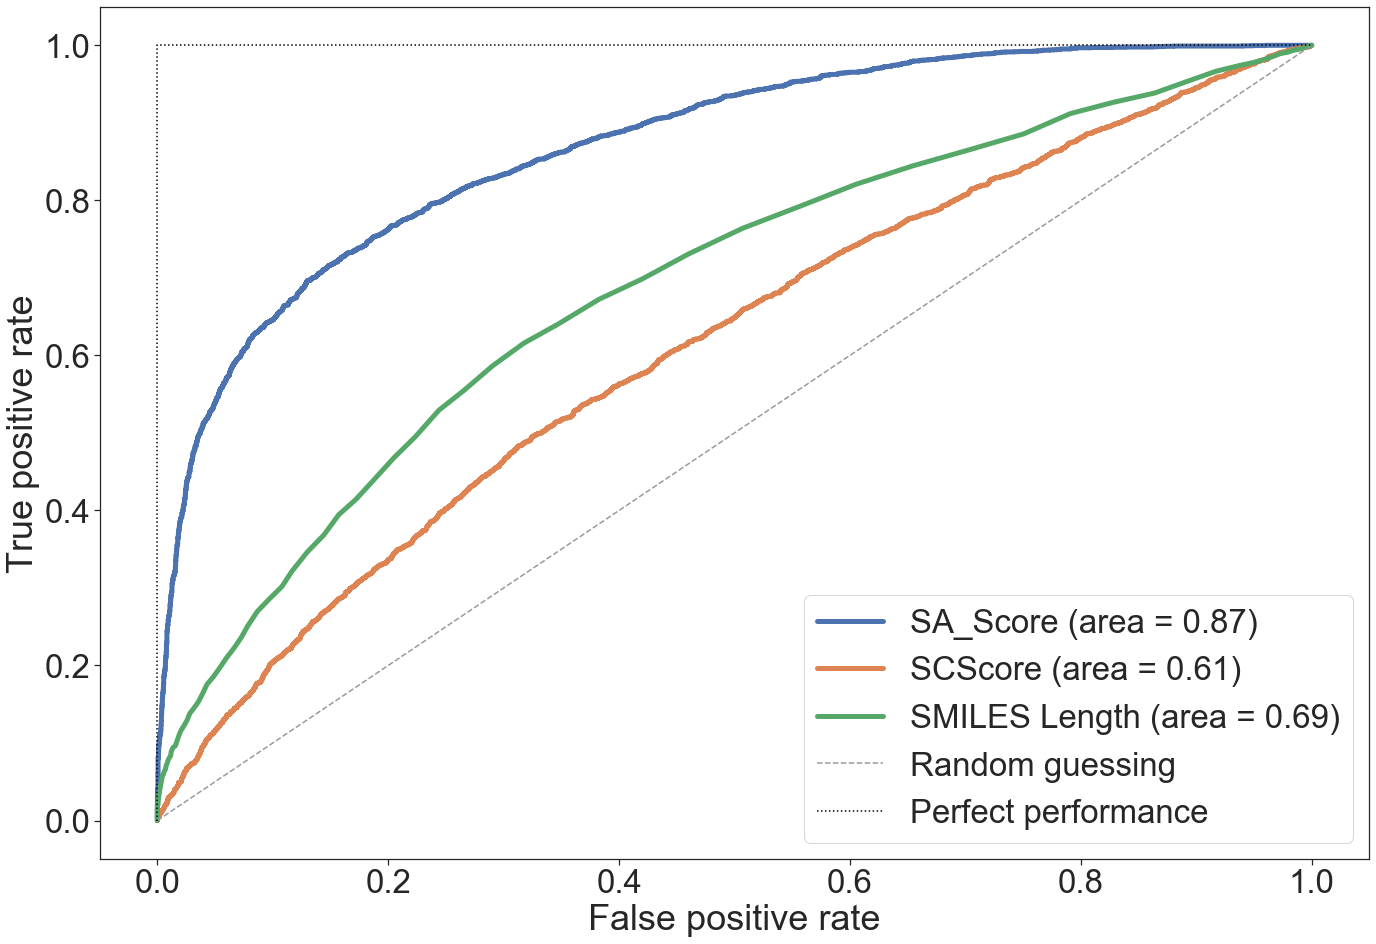

In [10]:
df = df_datasets_01[df_datasets_01['dataset'] != 'gdb']

fig = plt.figure(figsize=[20, 14])

fpr, tpr, thresholds = roc_curve(y_true=df.tb_synthesizability.to_numpy(), 
                                 y_score=df.sa_score.to_numpy(), pos_label=0)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,
         tpr,
         linewidth=5,
         label='SA_Score (area = %0.2f)'
               % roc_auc)

fpr, tpr, thresholds = roc_curve(y_true=df.tb_synthesizability.to_numpy(), 
                                 y_score=df.sc_score.to_numpy(), pos_label=0)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,
         tpr,
         linewidth=5,
         label='SCScore (area = %0.2f)'
               % roc_auc)

fpr, tpr, thresholds = roc_curve(y_true=df.tb_synthesizability.to_numpy(), 
                                 y_score=df.len_smiles.to_numpy(), pos_label=0)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,
         tpr,
         linewidth=5,
         label='SMILES Length (area = %0.2f)'
               % roc_auc)

# df = df_datasets_01[df_datasets_01['dataset'] == 'sheridan']
# fpr, tpr, thresholds = roc_curve(y_true=df.tb_synthesizability.to_numpy(), 
#                                  y_score=df.mean_complexity.to_numpy(), pos_label=0)
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr,
#          tpr,
#          linewidth=5,
#          label='meanComplexity (area = %0.2f)'
#                % roc_auc)

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('./figure/heuristic_roc_curve.png')
# plt.show()

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


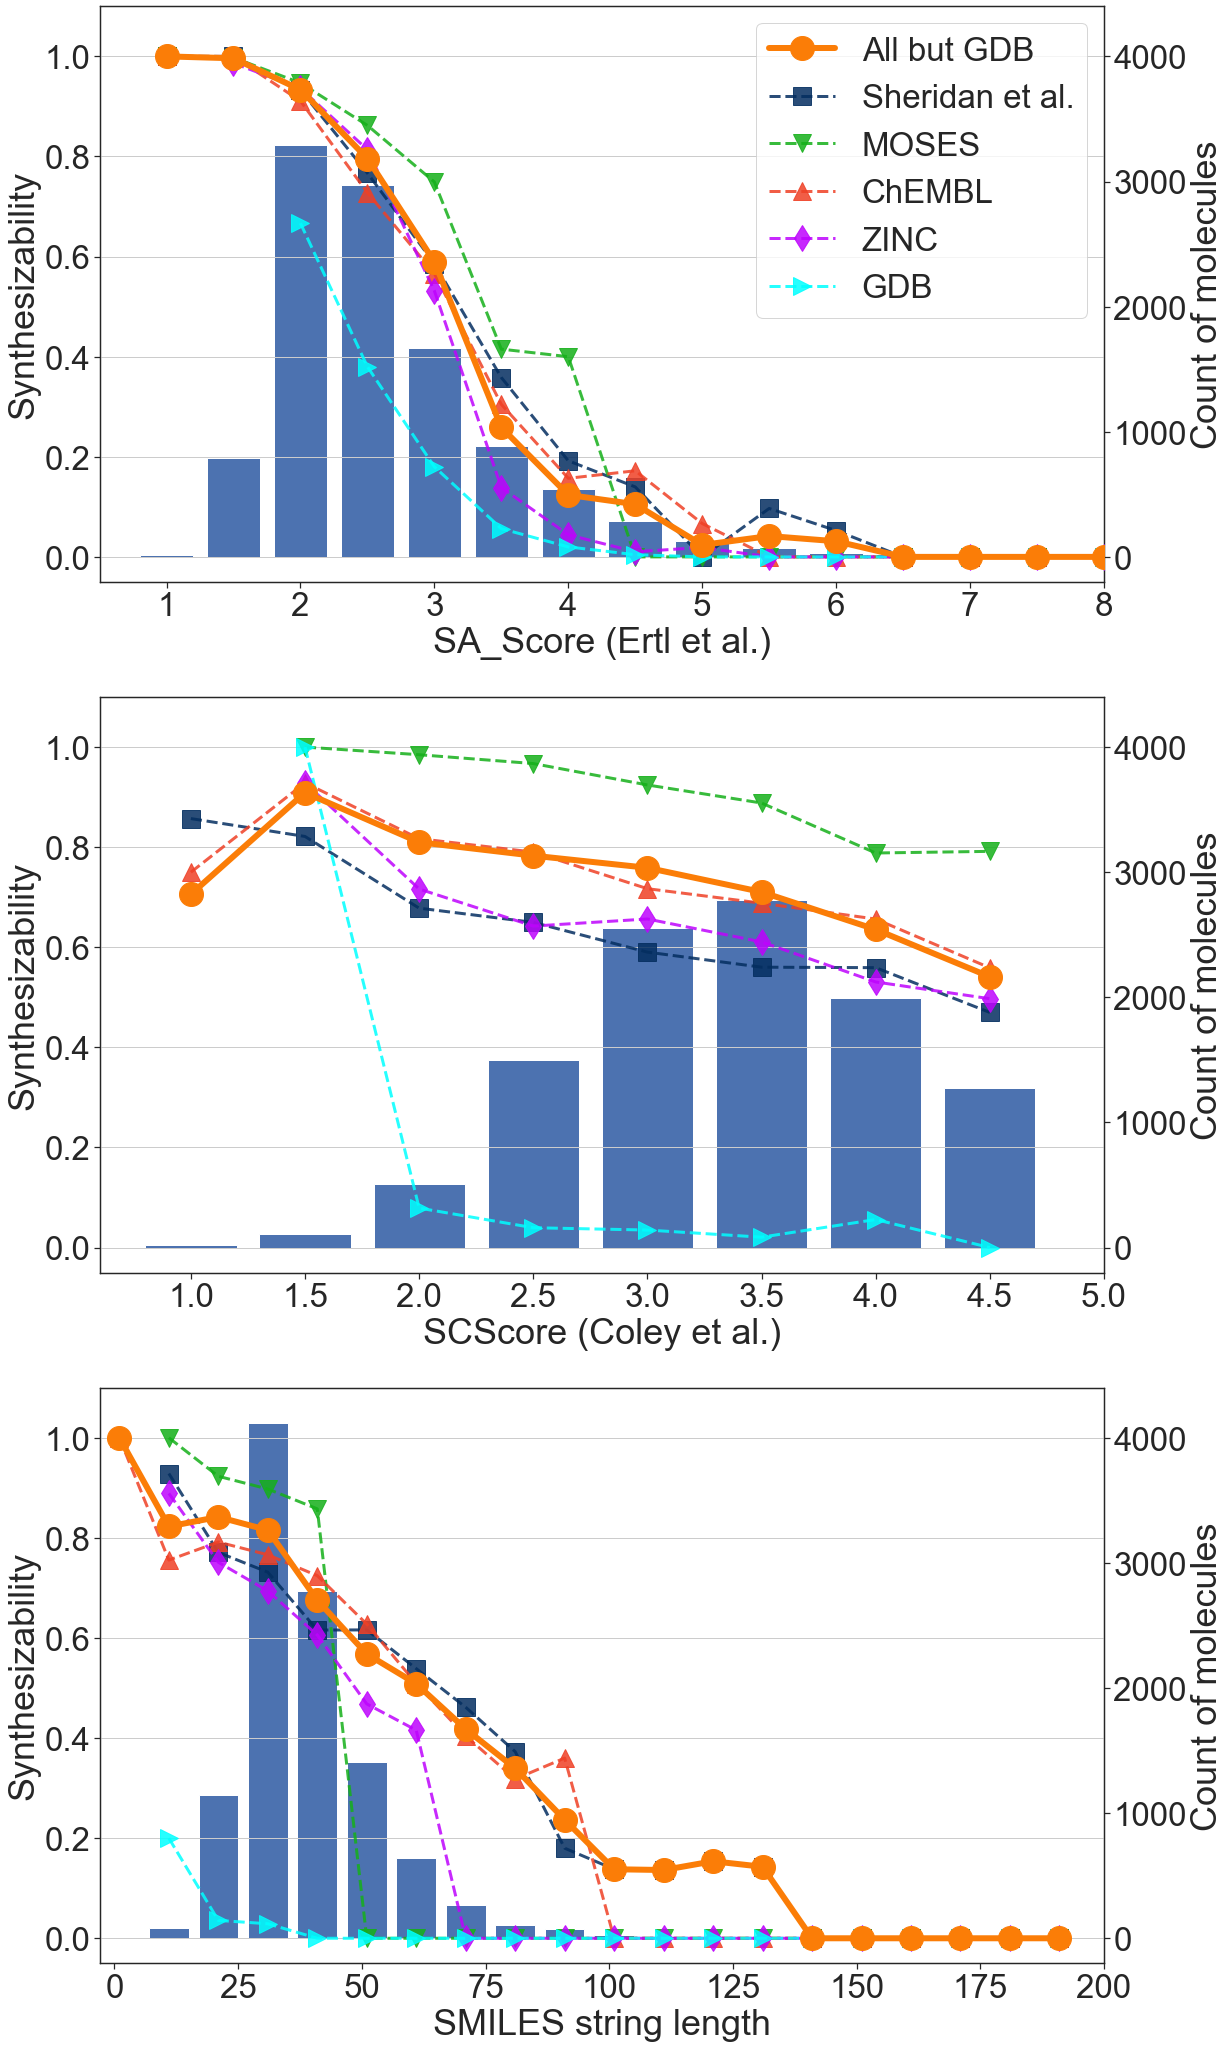

In [124]:
# sns.set(font_scale=3)

fig = plt.figure(figsize=[18, 36])

ax1 = fig.add_subplot(311)

ax2 = ax1.twinx()

df = df_datasets_01[df_datasets_01['dataset'] != 'gdb']
sas, ps, count = plot_curve_bar('sa_score', df, 1, 10, 0.5)
ax2.plot(sas, ps, marker='o', linestyle='-', color='xkcd:pumpkin orange', linewidth=6, alpha=1, label='All but GDB', zorder=30, markersize=24)
ax1.bar(sas, count, width=0.4, zorder=-1)

df = df_datasets_01[df_datasets_01['dataset'] == 'sheridan']
sas, ps = plot_curve('sa_score', df, 1, 10, 0.5)
ax2.plot(sas, ps, marker='s', linestyle='dashed', color='xkcd:marine', linewidth=3, alpha=0.85, label='Sheridan et al.', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'moses']
sas, ps = plot_curve('sa_score', df, 1, 10, 0.5)
ax2.plot(sas, ps, marker='v', linestyle='dashed', color='xkcd:green', linewidth=3, alpha=0.85, label='MOSES', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'guacamol']
sas, ps = plot_curve('sa_score', df, 1, 10, 0.5)
ax2.plot(sas, ps, marker='^', linestyle='dashed', color='xkcd:tomato', linewidth=3, alpha=0.85, label='ChEMBL', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'zinc']
sas, ps = plot_curve('sa_score', df, 1, 10, 0.5)
del ps[0], sas[0]
ax2.plot(sas, ps, marker='d', linestyle='dashed', color='xkcd:bright purple', linewidth=3, alpha=0.85, label='ZINC', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'gdb']
sas, ps = plot_curve('sa_score', df, 1, 10, 0.5)
del ps[0:2], sas[0:2]
ax2.plot(sas, ps, marker='>', linestyle='dashed', color='xkcd:cyan', linewidth=3, alpha=0.85, label='GDB', zorder=20, markersize=18)


ax3 = fig.add_subplot(312)

ax4 = ax3.twinx()

df = df_datasets_01[df_datasets_01['dataset'] == 'sheridan']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
ax4.plot(sas, ps, marker='s', linestyle='dashed', color='xkcd:marine', linewidth=3, alpha=0.85, label='Sheridan et al.', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'moses']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
del ps[0:1], sas[0:1]
ax4.plot(sas, ps, marker='v', linestyle='dashed', color='xkcd:green', linewidth=3, alpha=0.85, label='MOSES', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'guacamol']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
ax4.plot(sas, ps, marker='^', linestyle='dashed', color='xkcd:tomato', linewidth=3, alpha=0.85, label='ChEMBL', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'zinc']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
del ps[0:1], sas[0:1]
ax4.plot(sas, ps, marker='d', linestyle='dashed', color='xkcd:bright purple', linewidth=3, alpha=0.85, label='ZINC', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'gdb']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
del ps[0:1], sas[0:1]
ax4.plot(sas, ps, marker='>', linestyle='dashed', color='xkcd:cyan', linewidth=3, alpha=0.85, label='GDB', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] != 'gdb']
sas, ps, count = plot_curve_bar('sc_score', df, 1, 5, 0.5)
ax4.plot(sas, ps, marker='o', linestyle='-', color='xkcd:pumpkin orange', linewidth=6, alpha=1, label='All but GDB', zorder=30, markersize=24)
ax3.bar(sas, count, width=0.4)

ax5 = fig.add_subplot(313)

ax6 = ax5.twinx()

df = df_datasets_01[df_datasets_01['dataset'] == 'sheridan']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
ax6.plot(sas, ps, marker='s', linestyle='dashed', color='xkcd:marine', linewidth=3, alpha=0.85, label='Sheridan et al.', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'moses']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
ax6.plot(sas, ps, marker='v', linestyle='dashed', color='xkcd:green', linewidth=3, alpha=0.85, label='MOSES', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'guacamol']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
ax6.plot(sas, ps, marker='^', linestyle='dashed', color='xkcd:tomato', linewidth=3, alpha=0.85, label='ChEMBL', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'zinc']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
ax6.plot(sas, ps, marker='d', linestyle='dashed', color='xkcd:bright purple', linewidth=3, alpha=0.85, label='ZINC', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] == 'gdb']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
ax6.plot(sas, ps, marker='>', linestyle='dashed', color='xkcd:cyan', linewidth=3, alpha=0.85, label='GDB', zorder=20, markersize=18)

df = df_datasets_01[df_datasets_01['dataset'] != 'gdb']
sas, ps, count = plot_curve_bar('len_smiles', df, 1, 200, 10)
ax6.plot(sas, ps, marker='o', linestyle='-', color='xkcd:pumpkin orange', linewidth=6, alpha=1, label='All but GDB', zorder=30, markersize=24)
ax5.bar(sas, count, width=8)

ax2.set_xlim(0.5,8)
ax2.set_ylim(-0.05,1.1)
ax2.set_ylabel("Synthesizability")

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1.set_xlabel("SA_Score (Ertl et al.)")
ax1.set_ylim(-200,4400)
ax1.set_ylabel("Count of molecules")

ax4.set_xlim(0.6,5)
ax4.set_ylim(-0.05,1.1)
ax4.set_ylabel("Synthesizability")
ax3.set_xlabel("SCScore (Coley et al.)")
ax3.set_ylim(-200,4400)
ax3.set_ylabel("Count of molecules")

ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax4.yaxis.tick_left()
ax4.yaxis.set_label_position("left")

ax6.set_xlim(-3, 200)
ax6.set_ylim(-0.05,1.1)
ax6.set_ylabel("Synthesizability")
ax5.set_xlabel("SMILES string length")
ax5.set_ylim(-200,4400)
ax5.set_ylabel("Count of molecules")

ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ax6.yaxis.tick_left()
ax6.yaxis.set_label_position("left")

ax2.legend()
ax2.grid()
ax4.grid()
ax6.grid()

plt.show()
fig.savefig('./figure/heuristic_synthe_curve.png')

/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


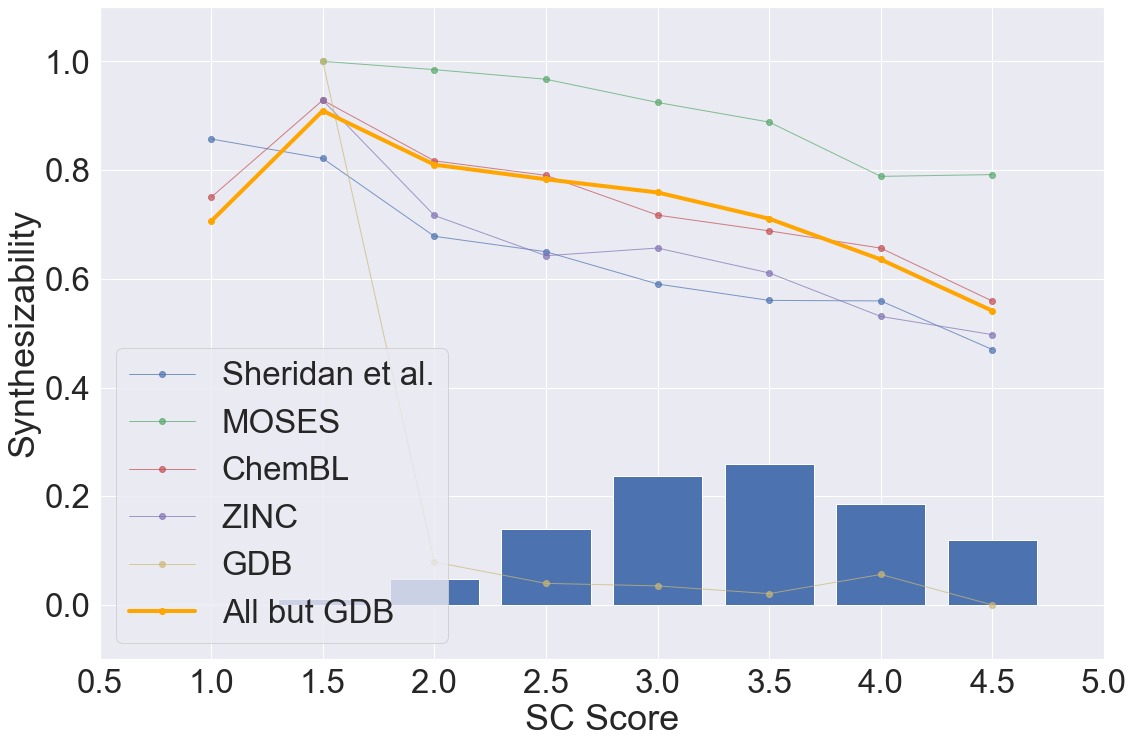

In [6]:
fig = plt.figure(figsize=[18, 12])
sns.set(font_scale=3)

df = df_datasets_01[df_datasets_01['dataset'] == 'sheridan']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
plt.plot(sas, ps, 'o-', color='b', linewidth=1, alpha=0.7, label='Sheridan et al.')

df = df_datasets_01[df_datasets_01['dataset'] == 'moses']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
del ps[0:1], sas[0:1]
plt.plot(sas, ps, 'o-', color='g', linewidth=1, alpha=0.7, label='MOSES')

df = df_datasets_01[df_datasets_01['dataset'] == 'guacamol']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
plt.plot(sas, ps, 'o-', color='r', linewidth=1, alpha=0.7, label='ChemBL')

df = df_datasets_01[df_datasets_01['dataset'] == 'zinc']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
del ps[0:1], sas[0:1]
plt.plot(sas, ps, 'o-', color='m', linewidth=1, alpha=0.7, label='ZINC')

df = df_datasets_01[df_datasets_01['dataset'] == 'gdb']
sas, ps = plot_curve('sc_score', df, 1, 5, 0.5)
del ps[0:1], sas[0:1]
plt.plot(sas, ps, 'o-', color='y', linewidth=1, alpha=0.7, label='GDB')

df = df_datasets_01[df_datasets_01['dataset'] != 'gdb']
sas, ps, count = plot_curve_bar('sc_score', df, 1, 5, 0.5)
plt.plot(sas, ps, 'o-', color='orange', linewidth=4, alpha=1, label='All but GDB')
plt.bar(sas, count, width=0.4)

plt.xlim(0.5,5)
plt.ylim(-0.1,1.1)
plt.xlabel("SC Score")
plt.ylabel("Synthesizability")
plt.legend()
fig.savefig('./figure/sc_synthe_curve.png')

/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


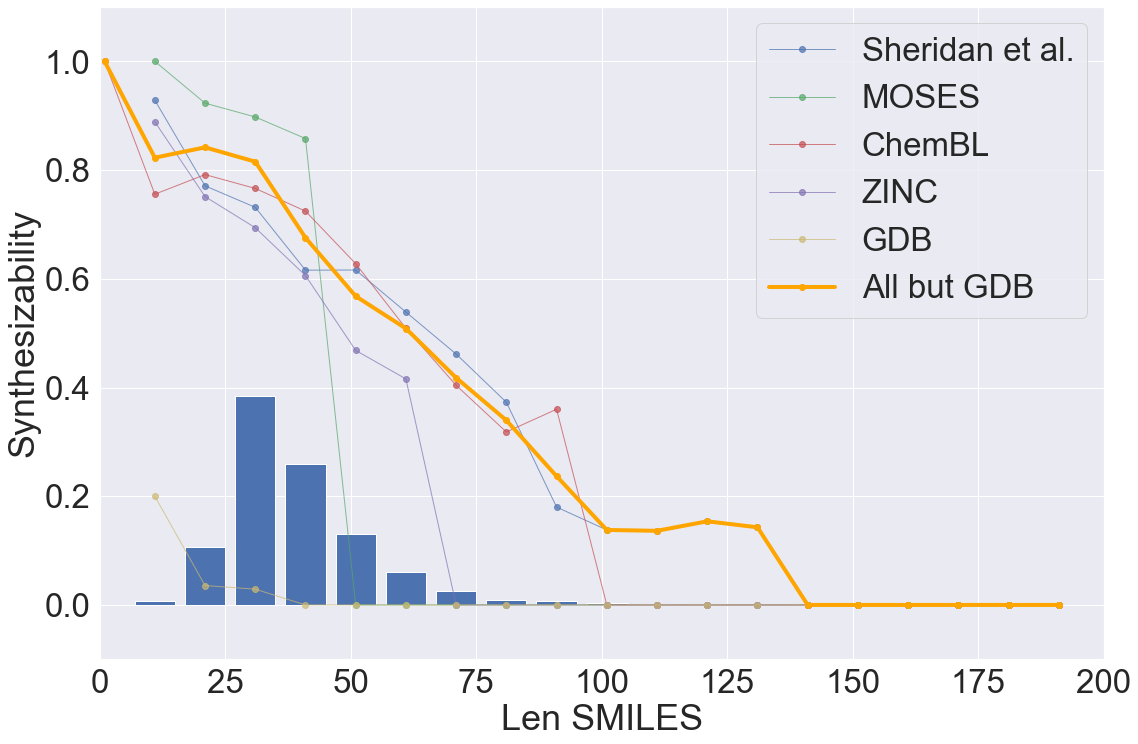

In [109]:
fig = plt.figure(figsize=[18, 12])
sns.set(font_scale=3)

df = df_datasets_01[df_datasets_01['dataset'] == 'sheridan']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
plt.plot(sas, ps, 'o-', color='b', linewidth=1, alpha=0.7, label='Sheridan et al.')

df = df_datasets_01[df_datasets_01['dataset'] == 'moses']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
plt.plot(sas, ps, 'o-', color='g', linewidth=1, alpha=0.7, label='MOSES')

df = df_datasets_01[df_datasets_01['dataset'] == 'guacamol']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
plt.plot(sas, ps, 'o-', color='r', linewidth=1, alpha=0.7, label='ChemBL')

df = df_datasets_01[df_datasets_01['dataset'] == 'zinc']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
plt.plot(sas, ps, 'o-', color='m', linewidth=1, alpha=0.7, label='ZINC')

df = df_datasets_01[df_datasets_01['dataset'] == 'gdb']
sas, ps = plot_curve('len_smiles', df, 1, 200, 10)
del ps[0:1], sas[0:1]
plt.plot(sas, ps, 'o-', color='y', linewidth=1, alpha=0.7, label='GDB')

df = df_datasets_01[df_datasets_01['dataset'] != 'gdb']
sas, ps, count = plot_curve_bar('len_smiles', df, 1, 200, 10)
plt.plot(sas, ps, 'o-', color='orange', linewidth=4, alpha=1, label='All but GDB')
plt.bar(sas, count, width=8)

plt.xlim(0,200)
plt.ylim(-0.1,1.1)
plt.xlabel("Len SMILES")
plt.ylabel("Synthesizability")
plt.legend()
fig.savefig('./figure/smi_synthe_curve.png')

In [41]:
df_datasets

SMILES   dataset  \
0                          CN(C)CCCN1c2ccccc2CCc2ccccc12  sheridan   
1                    CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1  sheridan   
2      C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N  sheridan   
3                           Nc1ccc(cc1)S(=O)(=O)Nc1nccs1  sheridan   
4                   CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O  sheridan   
...                                                  ...       ...   
13725                   CC1C2CC(=O)C(CC1=O)C1CC(CC21)C#N       gdb   
13726                      C1CC2C3CC(CN2C1)C1CNC(C3)C=C1       gdb   
13727                    CCC(CC)(N=C1NC(O)=CC(F)=C1F)C#N       gdb   
13728                         CC1=C2SC=C1CCCNC1C=C2NC1=O       gdb   
13729                         CCN1CC(=O)CCCC1C1OC2CCC1O2       gdb   

       len_smiles  mean_complexity  sa_score  sc_score  tb_depth  \
0              29         1.938462  1.933100  3.093000         0   
1              35         1.650000  2.435800  3.471000         0   
2              49         2.055556  2.808600  3.777200         0   
3              28         1.432432  2.031700  2.313300         0   
4              36         2.305556  3.712100  2.521600         0   
...           ...              ...       ...       ...       ...   
13725          32              NaN  5.419321  2.797630        11   
13726          29              NaN  5.597288  3.909670        11   
13727          31              NaN  3.981537  2.938651        11   
13728          26              NaN  5.416453  3.580676        11   
13729          26              NaN  5.052316  3.464176        11   

       tb_plausibility  tb_price tb_synthesizability  
0                  1.0       7.0       Synthesizable  
1                  1.0      24.0       Synthesizable  
2                  1.0      10.0       Synthesizable  
3                  1.0       1.0       Synthesizable  
4                  1.0       8.0       Synthesizable  
...                ...       ...                 ...  
13725              0.0      -1.0     Unsynthesizable  
13726              0.0      -1.0     Unsynthesizable  
13727              0.0      -1.0     Unsynthesizable  
13728              0.0      -1.0     Unsynthesizable  
13729              0.0      -1.0     Unsynthesizable  

[13730 rows x 10 columns]

In [42]:
len(df_datasets[df_datasets['dataset'] == 'sheridan'])

1730

In [6]:
df_count = count_plot(df_datasets, 'dataset', 'tb_depth')
df_count = normalize(df_count, axis=1)
df_count

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0         1         2         3         4         5   \
sheridan  0.045665  0.058382  0.080347  0.078613  0.069942  0.061272   
guacamol  0.009333  0.126000  0.130333  0.107000  0.095667  0.067333   
gdb       0.000000  0.000000  0.001667  0.002333  0.006333  0.004000   
zinc      0.002333  0.126667  0.151333  0.124333  0.080000  0.046333   
moses     0.000333  0.208333  0.224333  0.184000  0.106667  0.071000   

                6         7         8         9         10        11  
sheridan  0.058382  0.042775  0.027746  0.026012  0.017919  0.432948  
guacamol  0.050667  0.041333  0.026667  0.017667  0.010667  0.317333  
gdb       0.005000  0.006333  0.005000  0.002667  0.001000  0.965667  
zinc      0.036000  0.018333  0.011333  0.010000  0.006667  0.386667  
moses     0.042000  0.029667  0.014000  0.012333  0.005000  0.102333

In [7]:
df_list = []
names = ['moses', 'guacamol', 'zinc', 'sheridan', 'gdb']
orders = [2, 1, 0, 3, 4]
for i, label in zip(orders, names):
    if label == 'guacamol':
        df_list.append(pd.DataFrame({'chembl': df_count.iloc[i, :]}).T)
    else:
        df_list.append(pd.DataFrame({label: df_count.iloc[i, :]}).T)
df_count = pd.concat(df_list)
df_count

0         1         2         3         4         5   \
moses     0.000000  0.000000  0.001667  0.002333  0.006333  0.004000   
chembl    0.009333  0.126000  0.130333  0.107000  0.095667  0.067333   
zinc      0.045665  0.058382  0.080347  0.078613  0.069942  0.061272   
sheridan  0.002333  0.126667  0.151333  0.124333  0.080000  0.046333   
gdb       0.000333  0.208333  0.224333  0.184000  0.106667  0.071000   

                6         7         8         9         10        11  
moses     0.005000  0.006333  0.005000  0.002667  0.001000  0.965667  
chembl    0.050667  0.041333  0.026667  0.017667  0.010667  0.317333  
zinc      0.058382  0.042775  0.027746  0.026012  0.017919  0.432948  
sheridan  0.036000  0.018333  0.011333  0.010000  0.006667  0.386667  
gdb       0.042000  0.029667  0.014000  0.012333  0.005000  0.102333

In [8]:
df_count = pd.read_csv('./data/dataset_count.csv', index_col='Unnamed: 0')
df_count

0         1         2         3         4         5  \
moses     0.000333  0.208333  0.224333  0.184000  0.106667  0.071000   
chembl    0.009333  0.126000  0.130333  0.107000  0.095667  0.067333   
zinc      0.002333  0.126667  0.151333  0.124333  0.080000  0.046333   
sheridan  0.045665  0.058382  0.080347  0.078613  0.069942  0.061272   
gdb       0.000000  0.000000  0.001667  0.002333  0.006333  0.004000   

                 6         7         8         9        10        11  
moses     0.042000  0.029667  0.014000  0.012333  0.005000  0.102333  
chembl    0.050667  0.041333  0.026667  0.017667  0.010667  0.317333  
zinc      0.036000  0.018333  0.011333  0.010000  0.006667  0.386667  
sheridan  0.058382  0.042775  0.027746  0.026012  0.017919  0.432948  
gdb       0.005000  0.006333  0.005000  0.002667  0.001000  0.965667

In [13]:
# df_dataset_count = df_count
# df_dataset_count.to_csv('./data/dataset_count.csv')

# Distribution Learning Analysis

In [128]:
df_dl = pd.read_csv('./data/dl.csv')
df_dataset_count = pd.read_csv('./data/dataset_count.csv')
df_dl_moses = df_dl[df_dl['dataset'] == 'moses']
df_dl_chembl = df_dl[df_dl['dataset'] == 'chembl']

In [129]:
df_moses_count = count_plot(df_dl_moses, 'method', 'tb_depth')
df_moses_count = normalize(df_moses_count, axis=1)

df_chembl_count = count_plot(df_dl_chembl, 'method', 'tb_depth')
df_chembl_count = normalize(df_chembl_count, axis=1)

df_moses_count = pd.concat([pd.DataFrame({'moses': df_dataset_count.iloc[0, :]}).T, df_moses_count])
df_chembl_count = pd.concat([pd.DataFrame({'chembl': df_dataset_count.iloc[1, :]}).T, df_chembl_count])

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [130]:
df_chembl_count

0         1         2         3         4         5  \
chembl         NaN       NaN       NaN       NaN       NaN       NaN   
aae       0.003333  0.143333  0.090000  0.106667  0.073333  0.063333   
vae       0.003333  0.106667  0.130000  0.083333  0.080000  0.063333   
char_rnn  0.006667  0.096667  0.113333  0.100000  0.093333  0.056667   

                 6         7         8         9  ...        11         2  \
chembl         NaN       NaN       NaN       NaN  ...  0.317333  0.130333   
aae       0.070000  0.036667  0.020000  0.016667  ...       NaN       NaN   
vae       0.056667  0.016667  0.030000  0.026667  ...       NaN       NaN   
char_rnn  0.053333  0.046667  0.016667  0.013333  ...       NaN       NaN   

              3          4          5          6          7          8  \
chembl    0.107  0.0956667  0.0673333  0.0506667  0.0413333  0.0266667   
aae         NaN        NaN        NaN        NaN        NaN        NaN   
vae         NaN        NaN        NaN        NaN        NaN        NaN   
char_rnn    NaN        NaN        NaN        NaN        NaN        NaN   

                  9 Unnamed: 0  
chembl    0.0176667     chembl  
aae             NaN        NaN  
vae             NaN        NaN  
char_rnn        NaN        NaN  

[4 rows x 25 columns]

In [131]:
df_moses_count

0         1         2         3         4         5  \
moses          NaN       NaN       NaN       NaN       NaN       NaN   
aae       0.000000  0.223333  0.226667  0.130000  0.083333  0.066667   
vae       0.000000  0.236667  0.233333  0.183333  0.110000  0.050000   
char_rnn  0.003333  0.230000  0.203333  0.180000  0.113333  0.070000   

                 6         7         8         9  ...        11         2  \
moses          NaN       NaN       NaN       NaN  ...  0.102333  0.224333   
aae       0.026667  0.016667  0.013333  0.000000  ...       NaN       NaN   
vae       0.023333  0.013333  0.003333  0.013333  ...       NaN       NaN   
char_rnn  0.043333  0.023333  0.013333  0.006667  ...       NaN       NaN   

              3         4      5      6          7      8          9  \
moses     0.184  0.106667  0.071  0.042  0.0296667  0.014  0.0123333   
aae         NaN       NaN    NaN    NaN        NaN    NaN        NaN   
vae         NaN       NaN    NaN    NaN        NaN    NaN        NaN   
char_rnn    NaN       NaN    NaN    NaN        NaN    NaN        NaN   

         Unnamed: 0  
moses         moses  
aae             NaN  
vae             NaN  
char_rnn        NaN  

[4 rows x 25 columns]

In [132]:
df_moses_count = pd.read_csv('./data/dl_moses_count.csv', index_col='Unnamed: 0')
df_chembl_count = pd.read_csv('./data/dl_chembl_count.csv', index_col='Unnamed: 0')

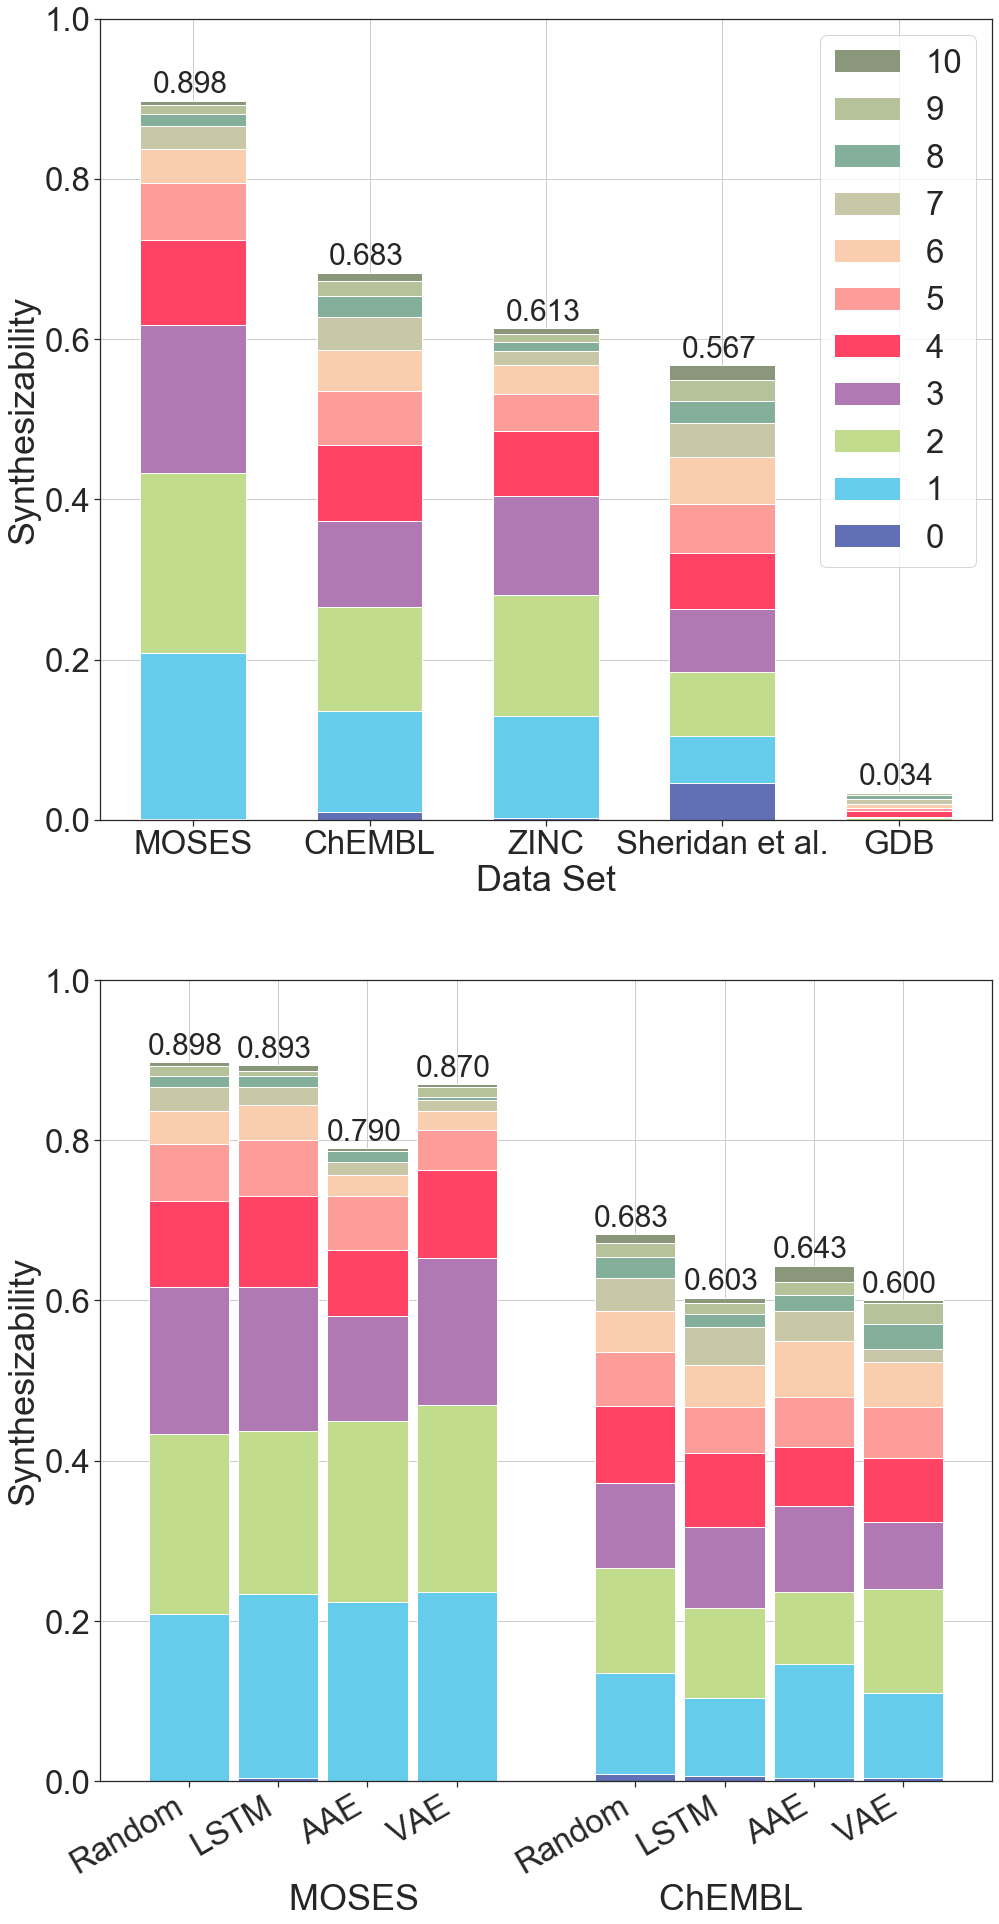

In [137]:
fig = plt.figure(figsize=[16, 36])
barWidth = 0.6
# base_color = [0.0,0.9,0.4,0.8]
colors = [
    [0.380, 0.435, 0.706],
    [0.396, 0.800, 0.925],
    [0.753, 0.863, 0.549],
    [0.694, 0.475, 0.706],
    [0.996, 0.263, 0.396],
    [0.988, 0.616, 0.604],
    [0.976, 0.804, 0.678],
    [0.784, 0.784, 0.663],
    [0.514, 0.686, 0.608],
    [0.714, 0.761, 0.604],
    [0.541, 0.592, 0.482],
    [0.957, 0.816, 0.000],
    [0.898, 0.514, 0.031],
    [0.863, 0.341, 0.071],
    [0.510, 0.224, 0.208]
]
color_id = 0
df_index = ['MOSES', 'ChEMBL', 'ZINC', 'Sheridan et al.', 'GDB']

ax1 = fig.add_subplot(211)

# ax1.bar(df_index, np.array(df_count['0']), label='0', width=barWidth, color=tuple(base_color))
ax1.bar(df_index, np.array(df_count['0']), label='0', width=barWidth, color=tuple(colors[color_id]))
color_id += 1
accum = np.array(df_count['0'])
for i in range(1, len(df_count.columns)-1):
    col_name = df_count.columns[i]
#     base_color[0] += 0.09
#     base_color[1] -= 0.08
#     base_color[2] += 0.01
#     base_color[3] += 0.02
#     ax1.bar(df_index, np.array(df_count[col_name]), 
#             bottom=accum, label=str(col_name), width=barWidth, color=tuple(base_color))
    ax1.bar(df_index, np.array(df_count[col_name]), 
            bottom=accum, label=str(col_name), width=barWidth, color=tuple(colors[color_id]))
    color_id += 1
    accum = accum + np.array(df_count[col_name])
    
label = ['0.898', '0.683', '0.613', '0.567', '0.034']
xs = [0, 1, 2, 3, 4]
for i in range(len(accum)):
    ax1.text(x = xs[i]-0.23 , y = accum[i]+0.01, s = label[i], size=30)

ax1.set_xlabel("Data Set")
ax1.set_ylabel("Synthesizability")
ax1.set_ylim(0, 1)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1])

# ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(212)

barWidth = 0.45

# base_color = [0.0,0.9,0.4,0.8]
color_id = 0
xs1 = list(np.arange(0, 1.6, 0.5))
# ax2.bar(xs1, np.array(df_moses_count['0']), label='0', width=barWidth, color=tuple(base_color))
ax2.bar(xs1, np.array(df_moses_count['0']), label='0', width=barWidth, color=tuple(colors[color_id]))
color_id += 1
accum1 = np.array(df_moses_count['0'])
for i in range(1, len(df_moses_count.columns)-1):
    col_name = df_moses_count.columns[i]
#     base_color[0] += 0.09
#     base_color[1] -= 0.08
#     base_color[2] += 0.01
#     ax2.bar(xs1, np.array(df_moses_count[col_name]), 
#             bottom=accum1, label=str(col_name), width=barWidth, color=tuple(base_color))
    ax2.bar(xs1, np.array(df_moses_count[col_name]), 
            bottom=accum1, label=str(col_name), width=barWidth, color=tuple(colors[color_id]))
    color_id += 1
    accum1 = accum1 + np.array(df_moses_count[col_name])
    
# plt.legend(loc='best')
    
# base_color = [0.0,0.9,0.4,0.8]
color_id = 0
distance = 2.5
xs2 = [x + distance for x in xs1]
# ax2.bar(xs2, np.array(df_chembl_count['0']), label='0', width=barWidth, color=tuple(base_color))
ax2.bar(xs2, np.array(df_chembl_count['0']), label='0', width=barWidth, color=tuple(colors[color_id]))
color_id += 1
accum2 = np.array(df_chembl_count['0'])
for i in range(1, len(df_chembl_count.columns)-1):
    col_name = df_chembl_count.columns[i]
#     base_color[0] += 0.09
#     base_color[1] -= 0.08
#     base_color[2] += 0.01
#     ax2.bar(xs2, np.array(df_chembl_count[col_name]), 
#             bottom=accum2, label=str(col_name), width=barWidth, color=tuple(base_color))
    ax2.bar(xs2, np.array(df_chembl_count[col_name]), 
            bottom=accum2, label=str(col_name), width=barWidth, color=tuple(colors[color_id]))
    color_id += 1
    accum2 = accum2 + np.array(df_chembl_count[col_name])
    
xlabels = ['Random', 'LSTM', 'AAE', 'VAE', 'Random', 'LSTM', 'AAE', 'VAE']
plt.xticks(xs1 + xs2, xlabels, rotation=30, horizontalalignment='right')
# ax2.set_xlabel(xlabels)

label = ['0.898', '0.893', '0.790', '0.870', '0.683', '0.603', '0.643', '0.600']
xs = xs1 + xs2
accum = list(accum1) + list(accum2)
for i in range(len(accum)):
    ax2.text(x = xs[i] - 0.23 , y = accum[i]+0.01, s = label[i], size=30)

ax2.set_xlim(-0.5, 4.5)
ax2.set_ylim(0, 1)
ax2.set_ylabel("Synthesizability")
ax2.set_xlabel("MOSES                        ChEMBL")
ax2.grid()

# plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2)
fig.savefig('./figure/all_barplot.png')

In [244]:
# df_moses_count.to_csv('./data/dl_moses_count.csv')
# df_chembl_count.to_csv('./data/dl_chembl_count.csv')

# Goal Directed Learning

In [52]:
df_goal_trivial_cwo = pd.read_csv('./data/chembl_wo.csv')
df_goal_trivial_cwa = pd.read_csv('./data/chembl_wa.csv')
df_goal_trivial_cwc = pd.read_csv('./data/chembl_wc.csv')

df_goal_trivial_mwo = pd.read_csv('./data/moses_wo.csv')
df_goal_trivial_mwa = pd.read_csv('./data/moses_wa.csv')
df_goal_trivial_mwc = pd.read_csv('./data/moses_wc.csv')

In [53]:
df_goal_hard_cwo = pd.read_csv('./data/goal_hard_cwo.csv')
df_goal_hard_cwa = pd.read_csv('./data/goal_hard_cwa.csv')
df_goal_hard_cwc = pd.read_csv('./data/goal_hard_cwc.csv')

df_goal_hard_mwo = pd.read_csv('./data/goal_hard_mwo.csv')
df_goal_hard_mwa = pd.read_csv('./data/goal_hard_mwa.csv')
df_goal_hard_mwc = pd.read_csv('./data/goal_hard_mwc.csv')

In [105]:
df_goal_pivot = make_pivot(df_goal_trivial_cwo, name='ChemBL original')
df_goal_pivot = df_goal_pivot.T
df_goal_pivot = df_goal_pivot.rename(columns={
    'smiles_lstm': 'SMILES LSTM',
    'smiles_ga': 'SMILES GA',
    'graph_ga': 'Graph GA',
    'best_from_chembl': 'Best from Data'
})
# df_goal_pivot = df_goal_pivot[['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA']]
df_goal_pivot = df_goal_pivot.reindex(index=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], columns=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
df_goal_pivot.columns.name = 'ChEMBL'
df_goal_pivot.index.name = 'No Biaisng'
df_goal_pivot

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ChEMBL            Best from Data  SMILES LSTM  SMILES GA  Graph GA
No Biaisng                                                        
CNS MPO                     0.68         0.54       0.71      0.69
QED                         0.85         0.94       0.79      0.86
C7H8N2O2                    0.88         0.89       0.71      0.77
Pioglitazone MPO            0.34         0.31       0.00      0.00

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


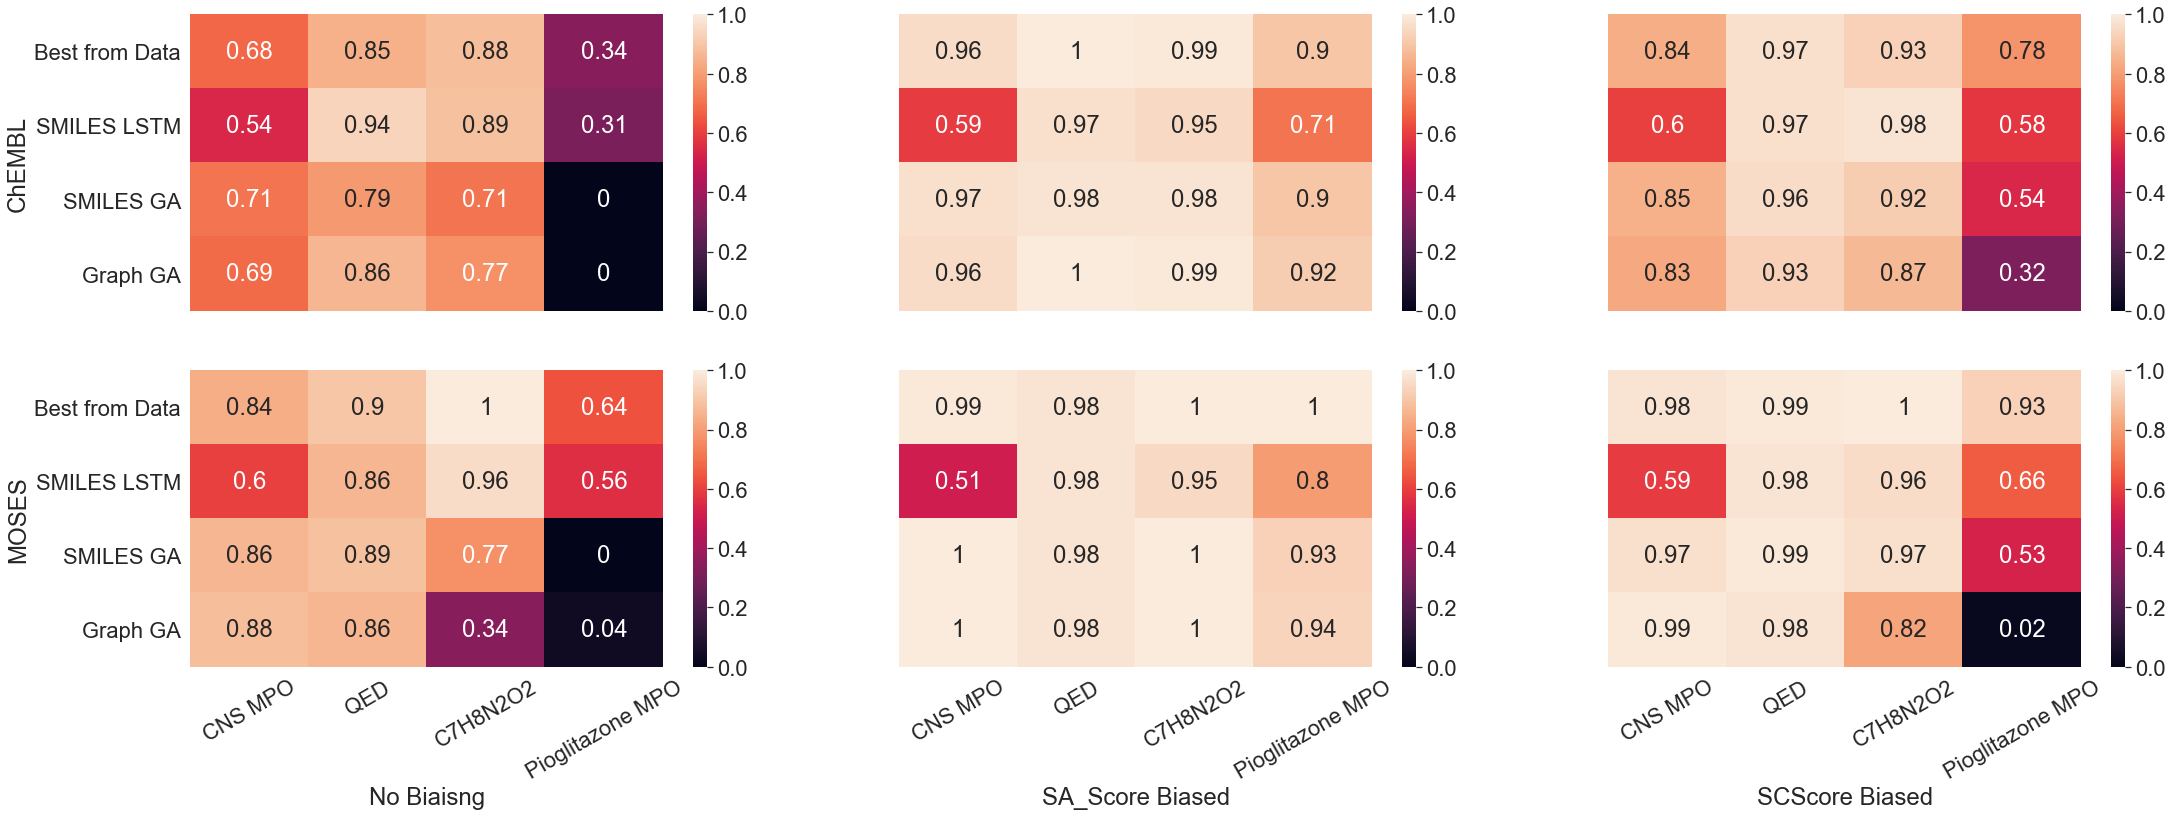

In [112]:
sns.set(font_scale=2)
fig = plt.figure(figsize=[36, 12])

df_goal_pivot = make_pivot(df_goal_trivial_cwo, name='ChemBL original')
df_goal_pivot = df_goal_pivot.T
df_goal_pivot = df_goal_pivot.rename(columns={
    'smiles_lstm': 'SMILES LSTM',
    'smiles_ga': 'SMILES GA',
    'graph_ga': 'Graph GA',
    'best_from_chembl': 'Best from Data'
})
df_goal_pivot = df_goal_pivot.reindex(index=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], columns=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
df_goal_pivot.columns.name = 'ChEMBL'
df_goal_pivot.index.name = ''

ax1 = plt.subplot(231)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax1, vmin=0, vmax=1, xticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_trivial_cwa, name='ChemBL with SA')
df_goal_pivot = df_goal_pivot.T
df_goal_pivot = df_goal_pivot.rename(columns={
    'smiles_lstm': 'SMILES LSTM',
    'smiles_ga': 'SMILES GA',
    'graph_ga': 'Graph GA',
    'best_from_chembl': 'Best from Data'
})
df_goal_pivot = df_goal_pivot.reindex(index=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], columns=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
df_goal_pivot.columns.name = ''
df_goal_pivot.index.name = ''

ax3 = plt.subplot(232)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax3, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_trivial_cwc, name='ChemBL with SC')
df_goal_pivot = df_goal_pivot.T
df_goal_pivot = df_goal_pivot.rename(columns={
    'smiles_lstm': 'SMILES LSTM',
    'smiles_ga': 'SMILES GA',
    'graph_ga': 'Graph GA',
    'best_from_chembl': 'Best from Data'
})
df_goal_pivot = df_goal_pivot.reindex(index=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], columns=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
df_goal_pivot.columns.name = ''
df_goal_pivot.index.name = ''

ax5 = plt.subplot(233)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax5, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_trivial_mwo, name='MOSES original')
df_goal_pivot = df_goal_pivot.T
df_goal_pivot = df_goal_pivot.rename(columns={
    'smiles_lstm': 'SMILES LSTM',
    'smiles_ga': 'SMILES GA',
    'graph_ga': 'Graph GA',
    'best_from_chembl': 'Best from Data'
})
df_goal_pivot = df_goal_pivot.reindex(index=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], columns=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
df_goal_pivot.columns.name = 'MOSES'
df_goal_pivot.index.name = 'No Biaisng'

ax2 = plt.subplot(234)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax2, vmin=0, vmax=1)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_trivial_mwa, name='MOSES with SA')
df_goal_pivot = df_goal_pivot.T
df_goal_pivot = df_goal_pivot.rename(columns={
    'smiles_lstm': 'SMILES LSTM',
    'smiles_ga': 'SMILES GA',
    'graph_ga': 'Graph GA',
    'best_from_chembl': 'Best from Data'
})
df_goal_pivot = df_goal_pivot.reindex(index=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], columns=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
df_goal_pivot.columns.name = ''
df_goal_pivot.index.name = 'SA_Score Biased'

ax4 = plt.subplot(235)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax4, vmin=0, vmax=1, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_trivial_mwc, name='MOSES with SC')
df_goal_pivot = df_goal_pivot.T
df_goal_pivot = df_goal_pivot.rename(columns={
    'smiles_lstm': 'SMILES LSTM',
    'smiles_ga': 'SMILES GA',
    'graph_ga': 'Graph GA',
    'best_from_chembl': 'Best from Data'
})
df_goal_pivot = df_goal_pivot.reindex(index=['CNS MPO', 'QED', 'C7H8N2O2', 'Pioglitazone MPO'], columns=['Best from Data', 'SMILES LSTM', 'SMILES GA', 'Graph GA'])
df_goal_pivot.columns.name = ''
df_goal_pivot.index.name = 'SCScore Biased'

ax6 = plt.subplot(236)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax6, vmin=0, vmax=1, yticklabels=False)
plt.xticks(rotation=30)

fig.savefig('./figure/goal_trivial_synthesizability_heatmap.png')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


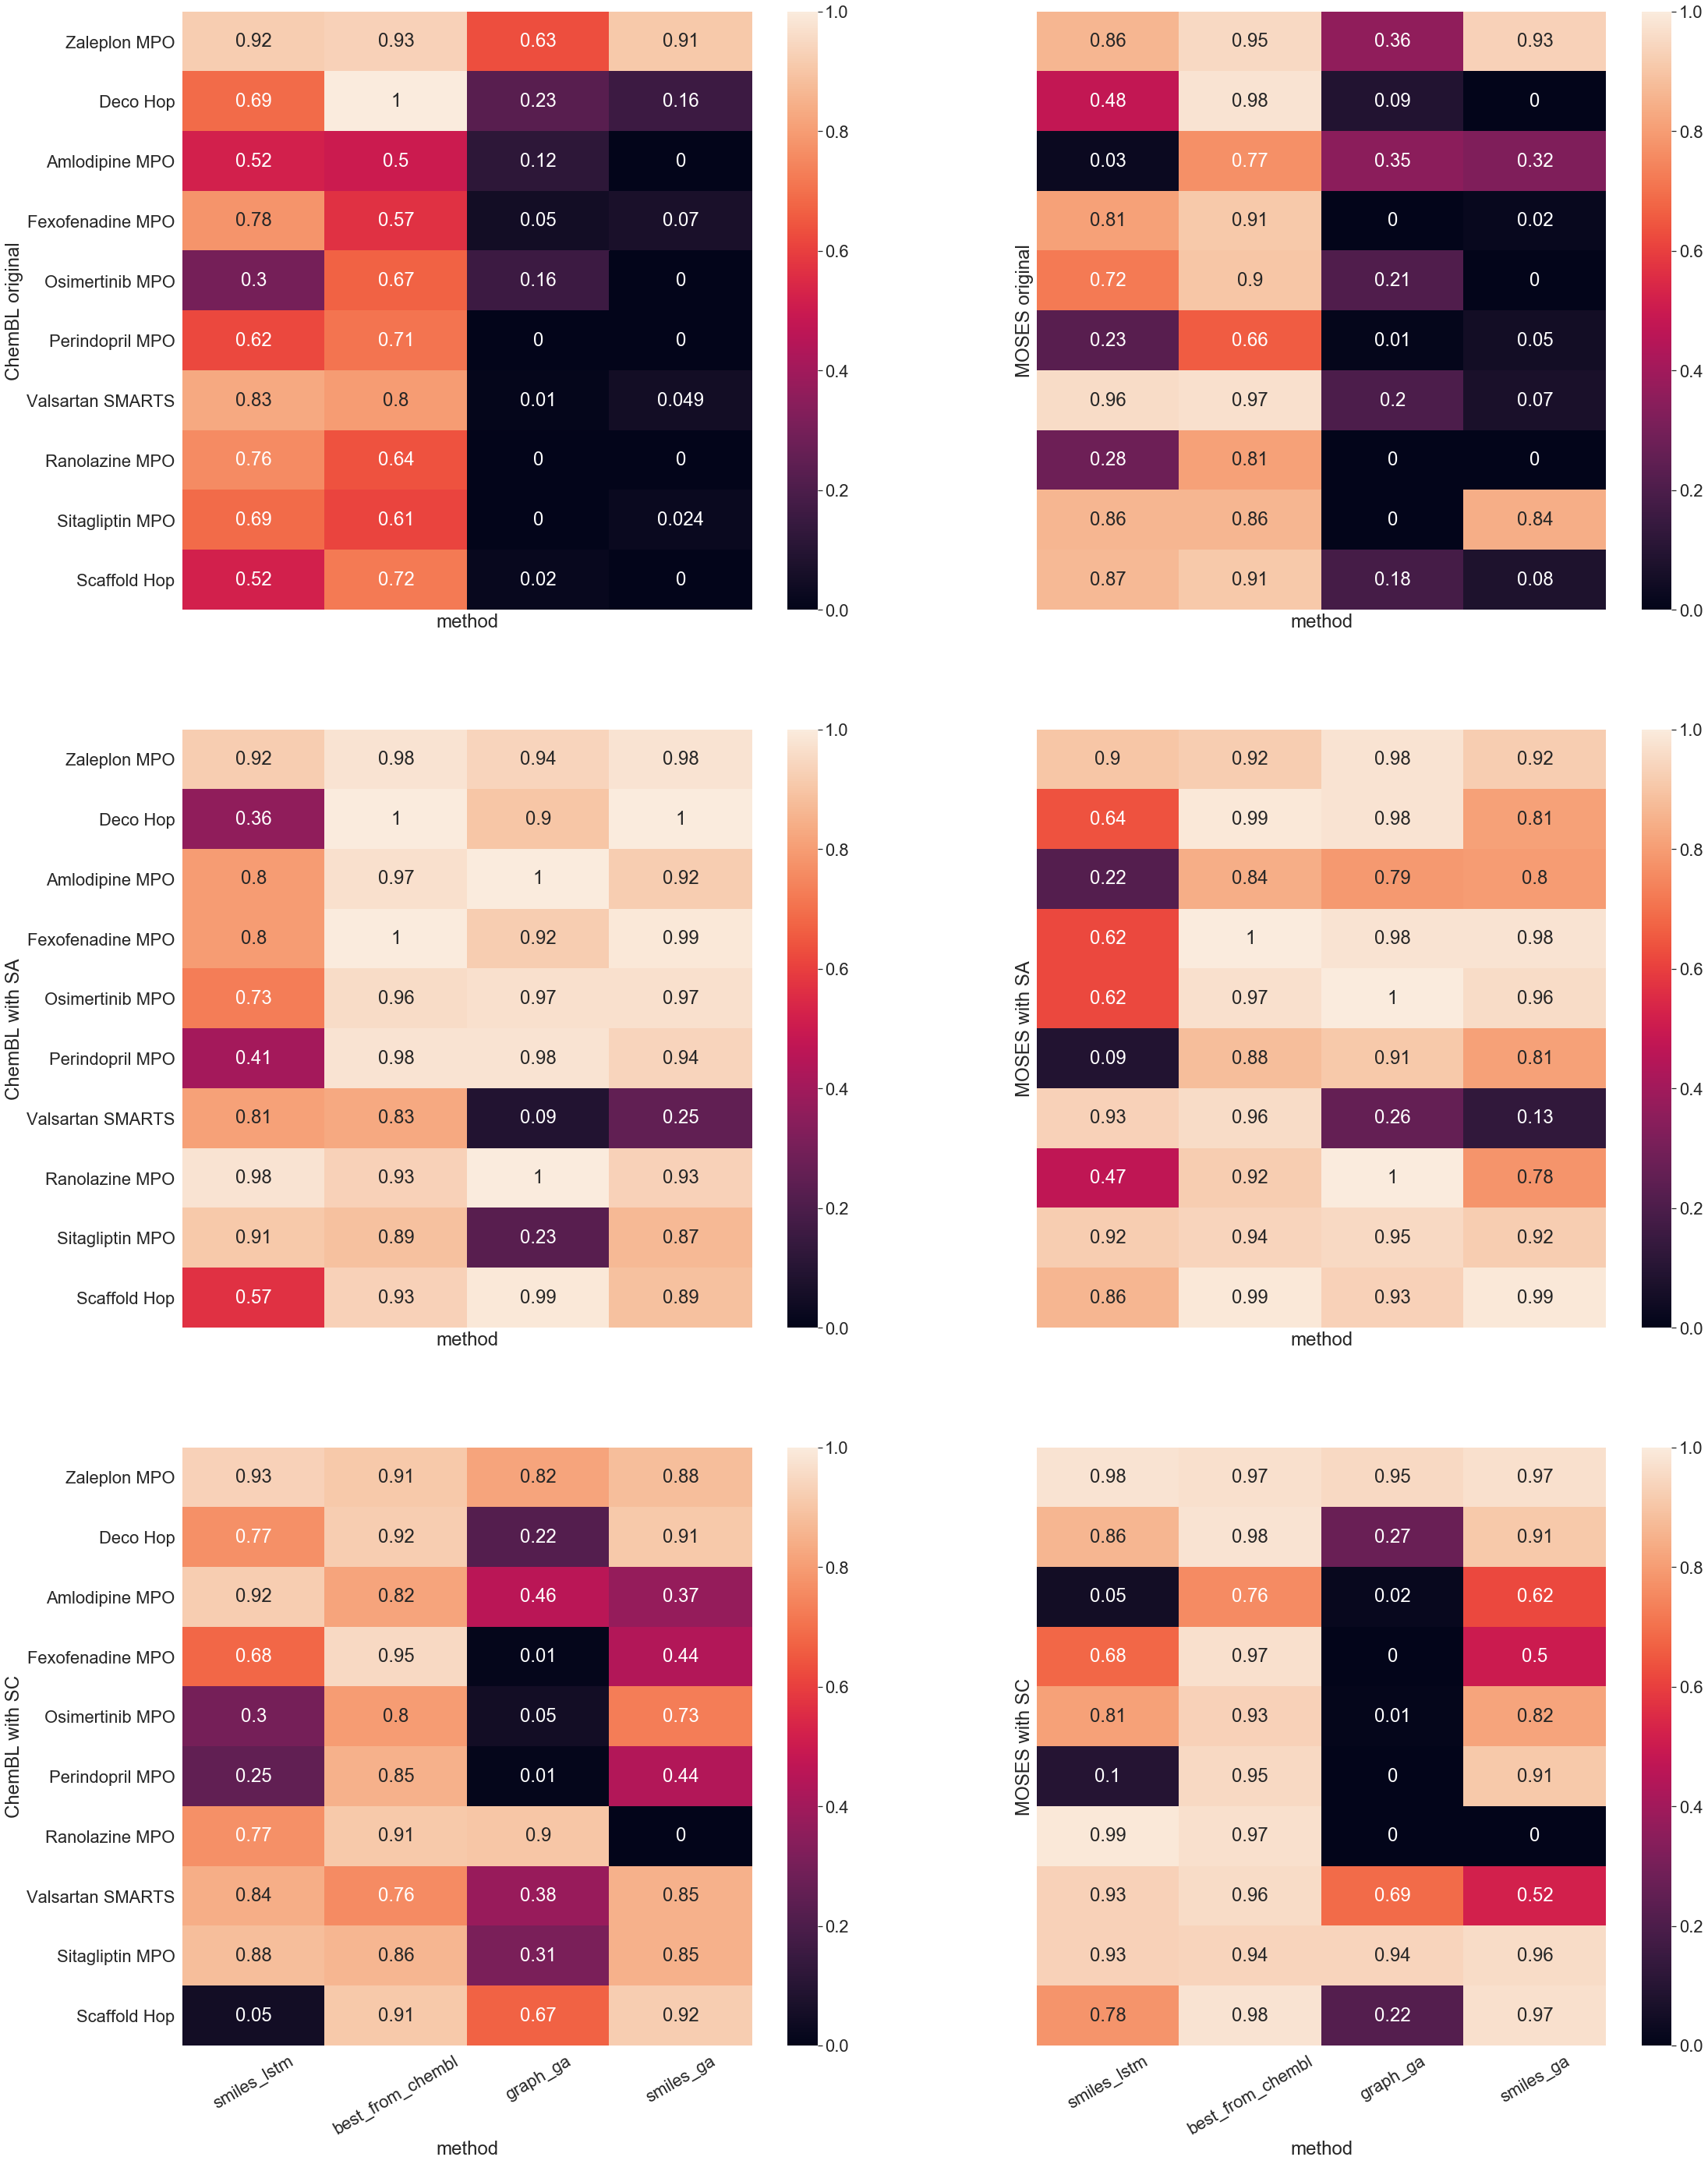

In [56]:
sns.set(font_scale=2)
fig = plt.figure(figsize=[36, 48])

df_goal_pivot = make_pivot(df_goal_hard_cwo, name='ChemBL original')
ax1 = plt.subplot(321)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax1, vmin=0, vmax=1, xticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_hard_cwa, name='ChemBL with SA')
ax3 = plt.subplot(323)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax3, vmin=0, vmax=1, xticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_hard_cwc, name='ChemBL with SC')
ax5 = plt.subplot(325)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax5, vmin=0, vmax=1)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_hard_mwo, name='MOSES original')
ax2 = plt.subplot(322)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax2, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_hard_mwa, name='MOSES with SA')
ax4 = plt.subplot(324)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax4, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_pivot(df_goal_hard_mwc, name='MOSES with SC')
ax6 = plt.subplot(326)
ax = sns.heatmap(df_goal_pivot.T, annot=True, fmt=".2g", annot_kws={'rotation':0}, ax=ax6, vmin=0, vmax=1, yticklabels=False)
plt.xticks(rotation=30)

fig.savefig('./figure/goal_hard_synthesizability_heatmap.png')

In [75]:
df_goal_trivial_cwo_synth = make_synth_data(df_goal_trivial_cwo)
df_goal_trivial_cwa_synth = make_synth_data(df_goal_trivial_cwa)
df_goal_trivial_cwc_synth = make_synth_data(df_goal_trivial_cwc)

df_goal_trivial_mwo_synth = make_synth_data(df_goal_trivial_mwo)
df_goal_trivial_mwa_synth = make_synth_data(df_goal_trivial_mwa)
df_goal_trivial_mwc_synth = make_synth_data(df_goal_trivial_mwc)

df_goal_trivial_cwo_s10 = calc_avg(df_goal_trivial_cwo_synth, 10, 'property', 'method')
df_goal_trivial_cwa_s10 = calc_avg(df_goal_trivial_cwa_synth, 10, 'property', 'method')
df_goal_trivial_cwc_s10 = calc_avg(df_goal_trivial_cwc_synth, 10, 'property', 'method')

df_goal_trivial_mwo_s10 = calc_avg(df_goal_trivial_mwo_synth, 10, 'property', 'method')
df_goal_trivial_mwa_s10 = calc_avg(df_goal_trivial_mwa_synth, 10, 'property', 'method')
df_goal_trivial_mwc_s10 = calc_avg(df_goal_trivial_mwc_synth, 10, 'property', 'method')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


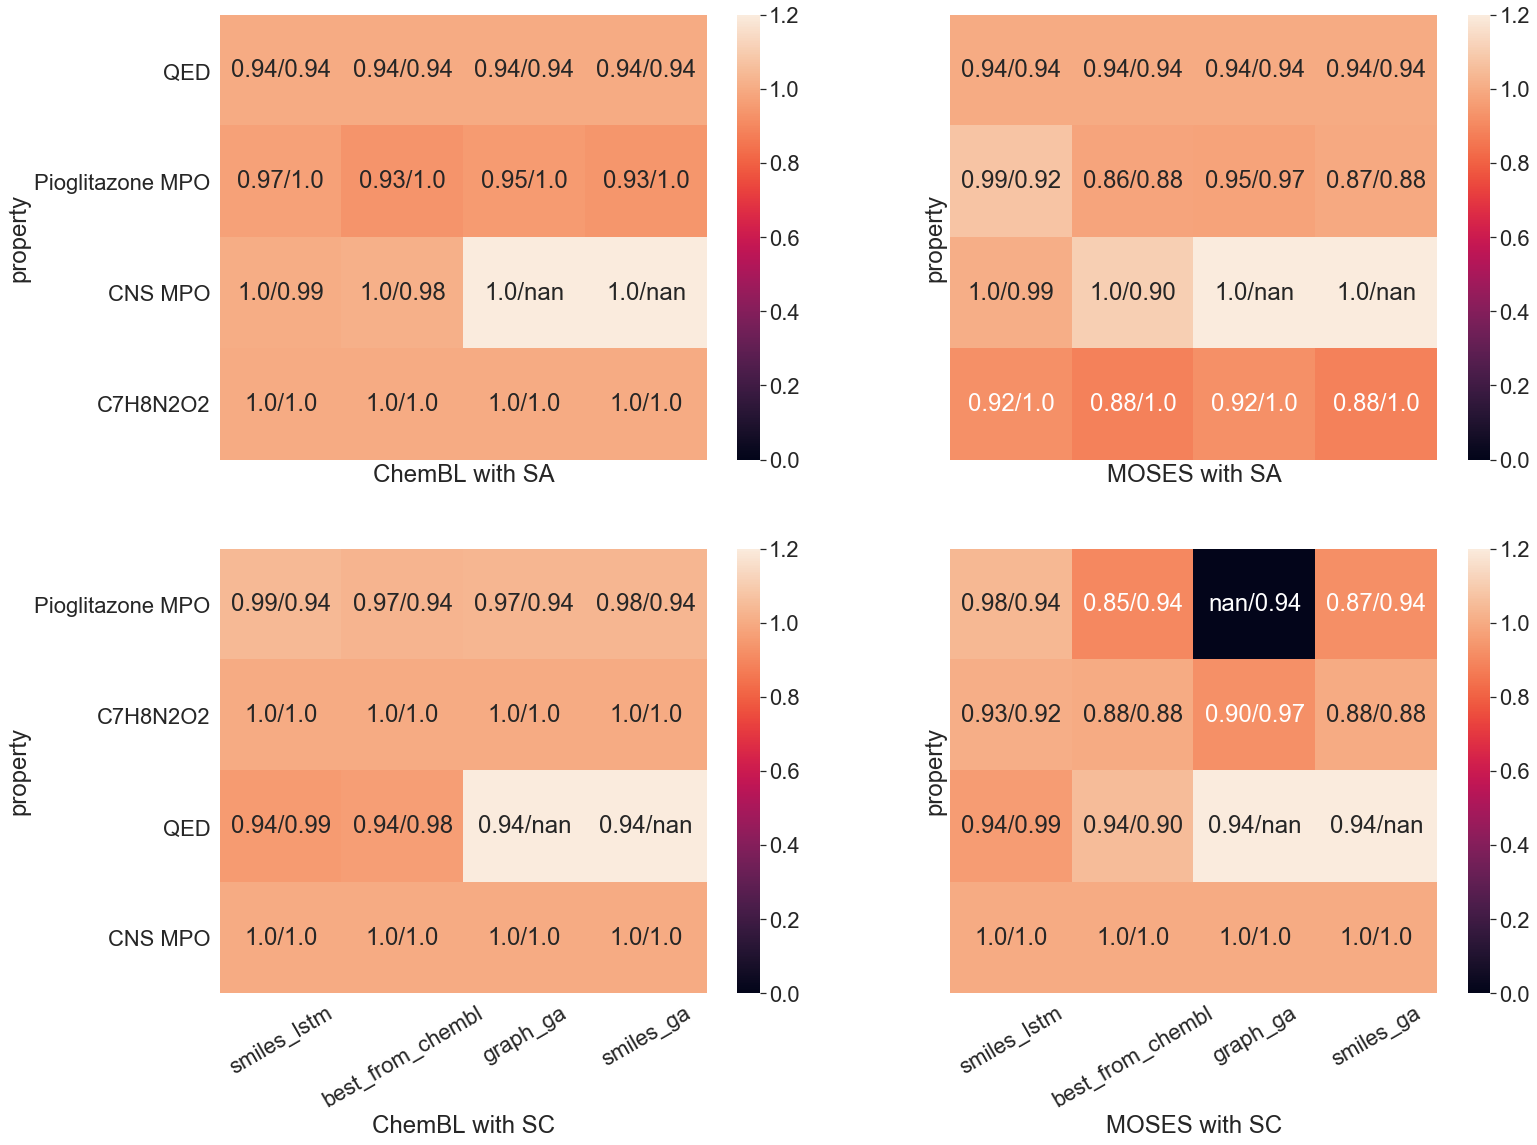

In [76]:
sns.set(font_scale=2)
fig = plt.figure(figsize=[24, 18])

df_goal_pivot = make_ratio(df_goal_trivial_cwa_s10, df_goal_trivial_cwo_s10, name='ChemBL with SA')
ax1 = plt.subplot(221)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_trivial_cwa_s10, df_goal_trivial_cwo_s10),\
                 fmt='s', ax=ax1, vmin=0, vmax=1.2, xticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_trivial_cwc_s10, df_goal_trivial_cwo_s10, name='ChemBL with SC')
ax3 = plt.subplot(223)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_trivial_cwc_s10, df_goal_trivial_cwo_s10),\
                 fmt='s', ax=ax3, vmin=0, vmax=1.2)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_trivial_mwa_s10, df_goal_trivial_mwo_s10, name='MOSES with SA')
ax2 = plt.subplot(222)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_trivial_mwa_s10, df_goal_trivial_mwo_s10),\
                 fmt='s', ax=ax2, vmin=0, vmax=1.2, xticklabels=False, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_trivial_mwc_s10, df_goal_trivial_mwo_s10, name='MOSES with SC')
ax4 = plt.subplot(224)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_trivial_mwc_s10, df_goal_trivial_mwo_s10),\
                 fmt='s', ax=ax4, vmin=0, vmax=1.2, yticklabels=False)
plt.xticks(rotation=30)


fig.savefig('./figure/goal_trivial_objective_heatmap.png')

In [77]:
df_goal_hard_cwo_synth = make_synth_data(df_goal_hard_cwo)
df_goal_hard_cwa_synth = make_synth_data(df_goal_hard_cwa)
df_goal_hard_cwc_synth = make_synth_data(df_goal_hard_cwc)

df_goal_hard_mwo_synth = make_synth_data(df_goal_hard_mwo)
df_goal_hard_mwa_synth = make_synth_data(df_goal_hard_mwa)
df_goal_hard_mwc_synth = make_synth_data(df_goal_hard_mwc)

df_goal_hard_cwo_s10 = calc_avg(df_goal_hard_cwo_synth, 10, 'property', 'method')
df_goal_hard_cwa_s10 = calc_avg(df_goal_hard_cwa_synth, 10, 'property', 'method')
df_goal_hard_cwc_s10 = calc_avg(df_goal_hard_cwc_synth, 10, 'property', 'method')

df_goal_hard_mwo_s10 = calc_avg(df_goal_hard_mwo_synth, 10, 'property', 'method')
df_goal_hard_mwa_s10 = calc_avg(df_goal_hard_mwa_synth, 10, 'property', 'method')
df_goal_hard_mwc_s10 = calc_avg(df_goal_hard_mwc_synth, 10, 'property', 'method')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


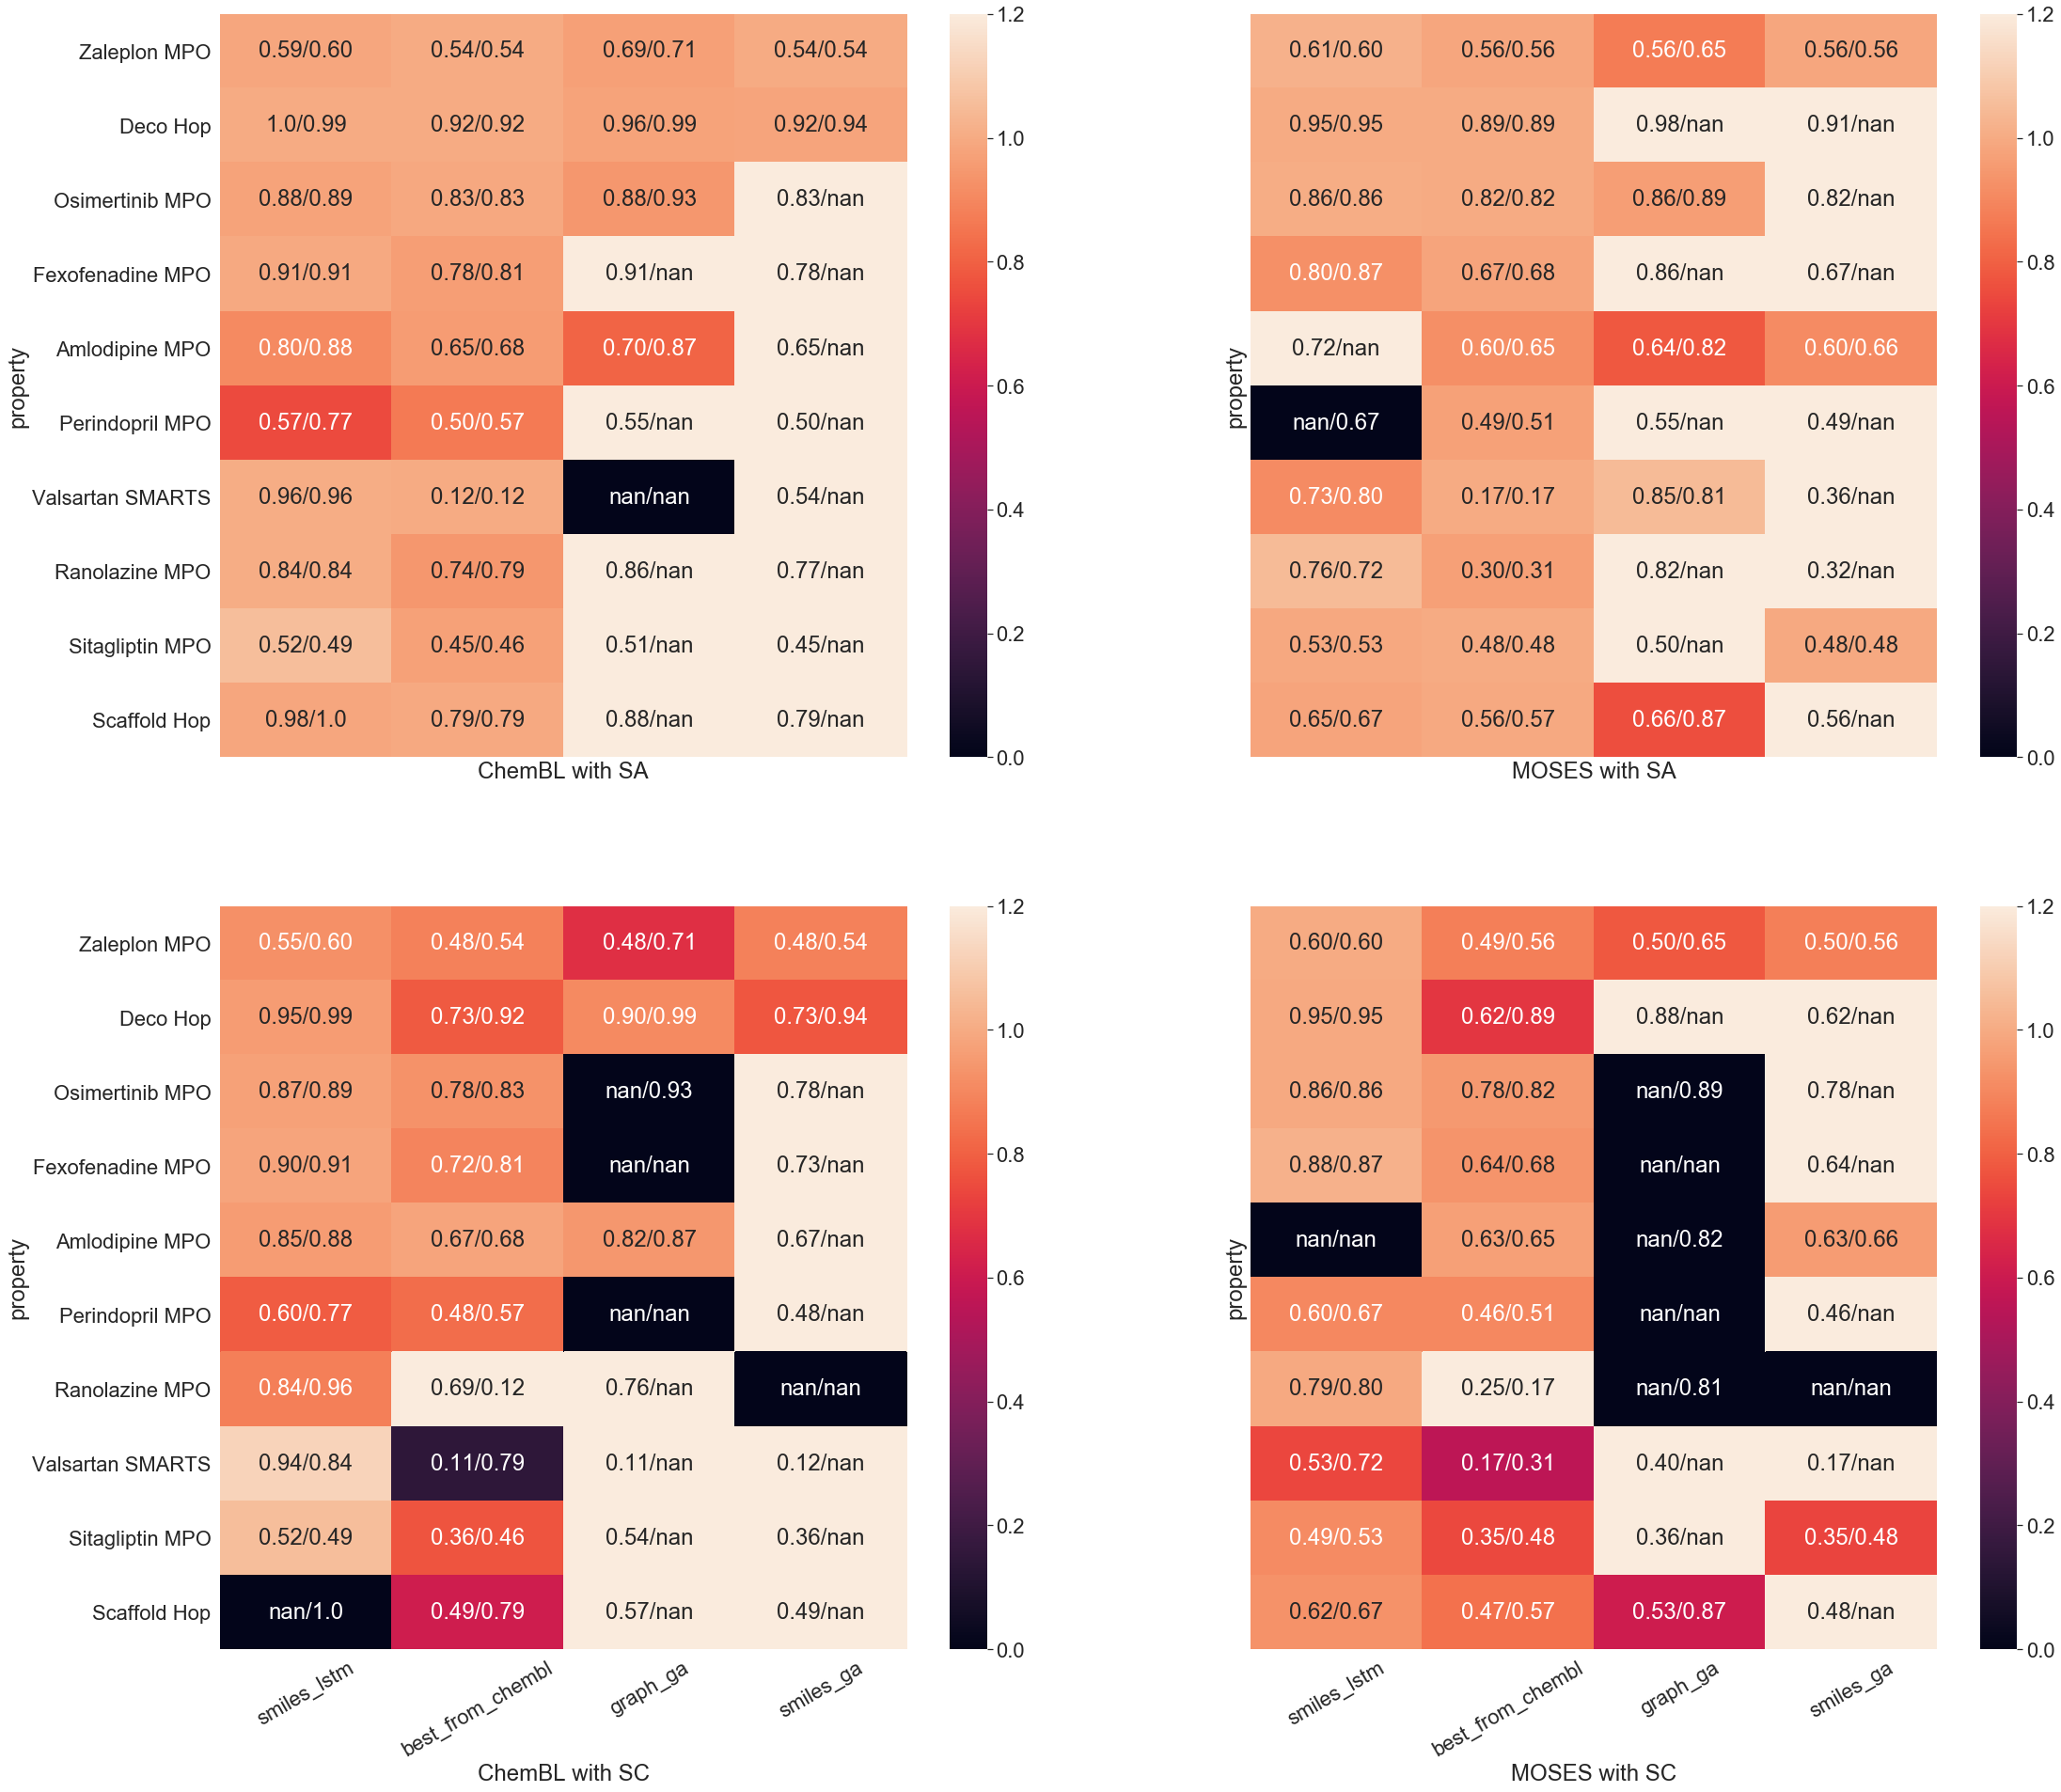

In [78]:
sns.set(font_scale=2)
fig = plt.figure(figsize=[36, 32])

df_goal_pivot = make_ratio(df_goal_hard_cwa_s10, df_goal_hard_cwo_s10, name='ChemBL with SA')
ax1 = plt.subplot(221)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_cwa_s10, df_goal_hard_cwo_s10),\
                 fmt='s', ax=ax1, vmin=0, vmax=1.2, xticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_hard_cwc_s10, df_goal_hard_cwo_s10, name='ChemBL with SC')
ax3 = plt.subplot(223)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_cwc_s10, df_goal_hard_cwo_s10),\
                 fmt='s', ax=ax3, vmin=0, vmax=1.2)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_hard_mwa_s10, df_goal_hard_mwo_s10, name='MOSES with SA')
ax2 = plt.subplot(222)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_mwa_s10, df_goal_hard_mwo_s10),\
                 fmt='s', ax=ax2, vmin=0, vmax=1.2, xticklabels=False, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_hard_mwc_s10, df_goal_hard_mwo_s10, name='MOSES with SC')
ax4 = plt.subplot(224)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_mwc_s10, df_goal_hard_mwo_s10),\
                 fmt='s', ax=ax4, vmin=0, vmax=1.2, yticklabels=False)
plt.xticks(rotation=30)


fig.savefig('./figure/goal_hard_objective_heatmap.png')

In [79]:
df_goal_hard_cwo_synth = make_synth_data(df_goal_hard_cwo)
df_goal_hard_cwa_synth = make_synth_data(df_goal_hard_cwa)
df_goal_hard_cwc_synth = make_synth_data(df_goal_hard_cwc)

df_goal_hard_mwo_synth = make_synth_data(df_goal_hard_mwo)
df_goal_hard_mwa_synth = make_synth_data(df_goal_hard_mwa)
df_goal_hard_mwc_synth = make_synth_data(df_goal_hard_mwc)

df_goal_hard_cwo_s1 = calc_avg(df_goal_hard_cwo_synth, 1, 'property', 'method')
df_goal_hard_cwa_s1 = calc_avg(df_goal_hard_cwa_synth, 1, 'property', 'method')
df_goal_hard_cwc_s1 = calc_avg(df_goal_hard_cwc_synth, 1, 'property', 'method')

df_goal_hard_mwo_s1 = calc_avg(df_goal_hard_mwo_synth, 1, 'property', 'method')
df_goal_hard_mwa_s1 = calc_avg(df_goal_hard_mwa_synth, 1, 'property', 'method')
df_goal_hard_mwc_s1 = calc_avg(df_goal_hard_mwc_synth, 1, 'property', 'method')

/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/Caskroom/miniconda/base/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


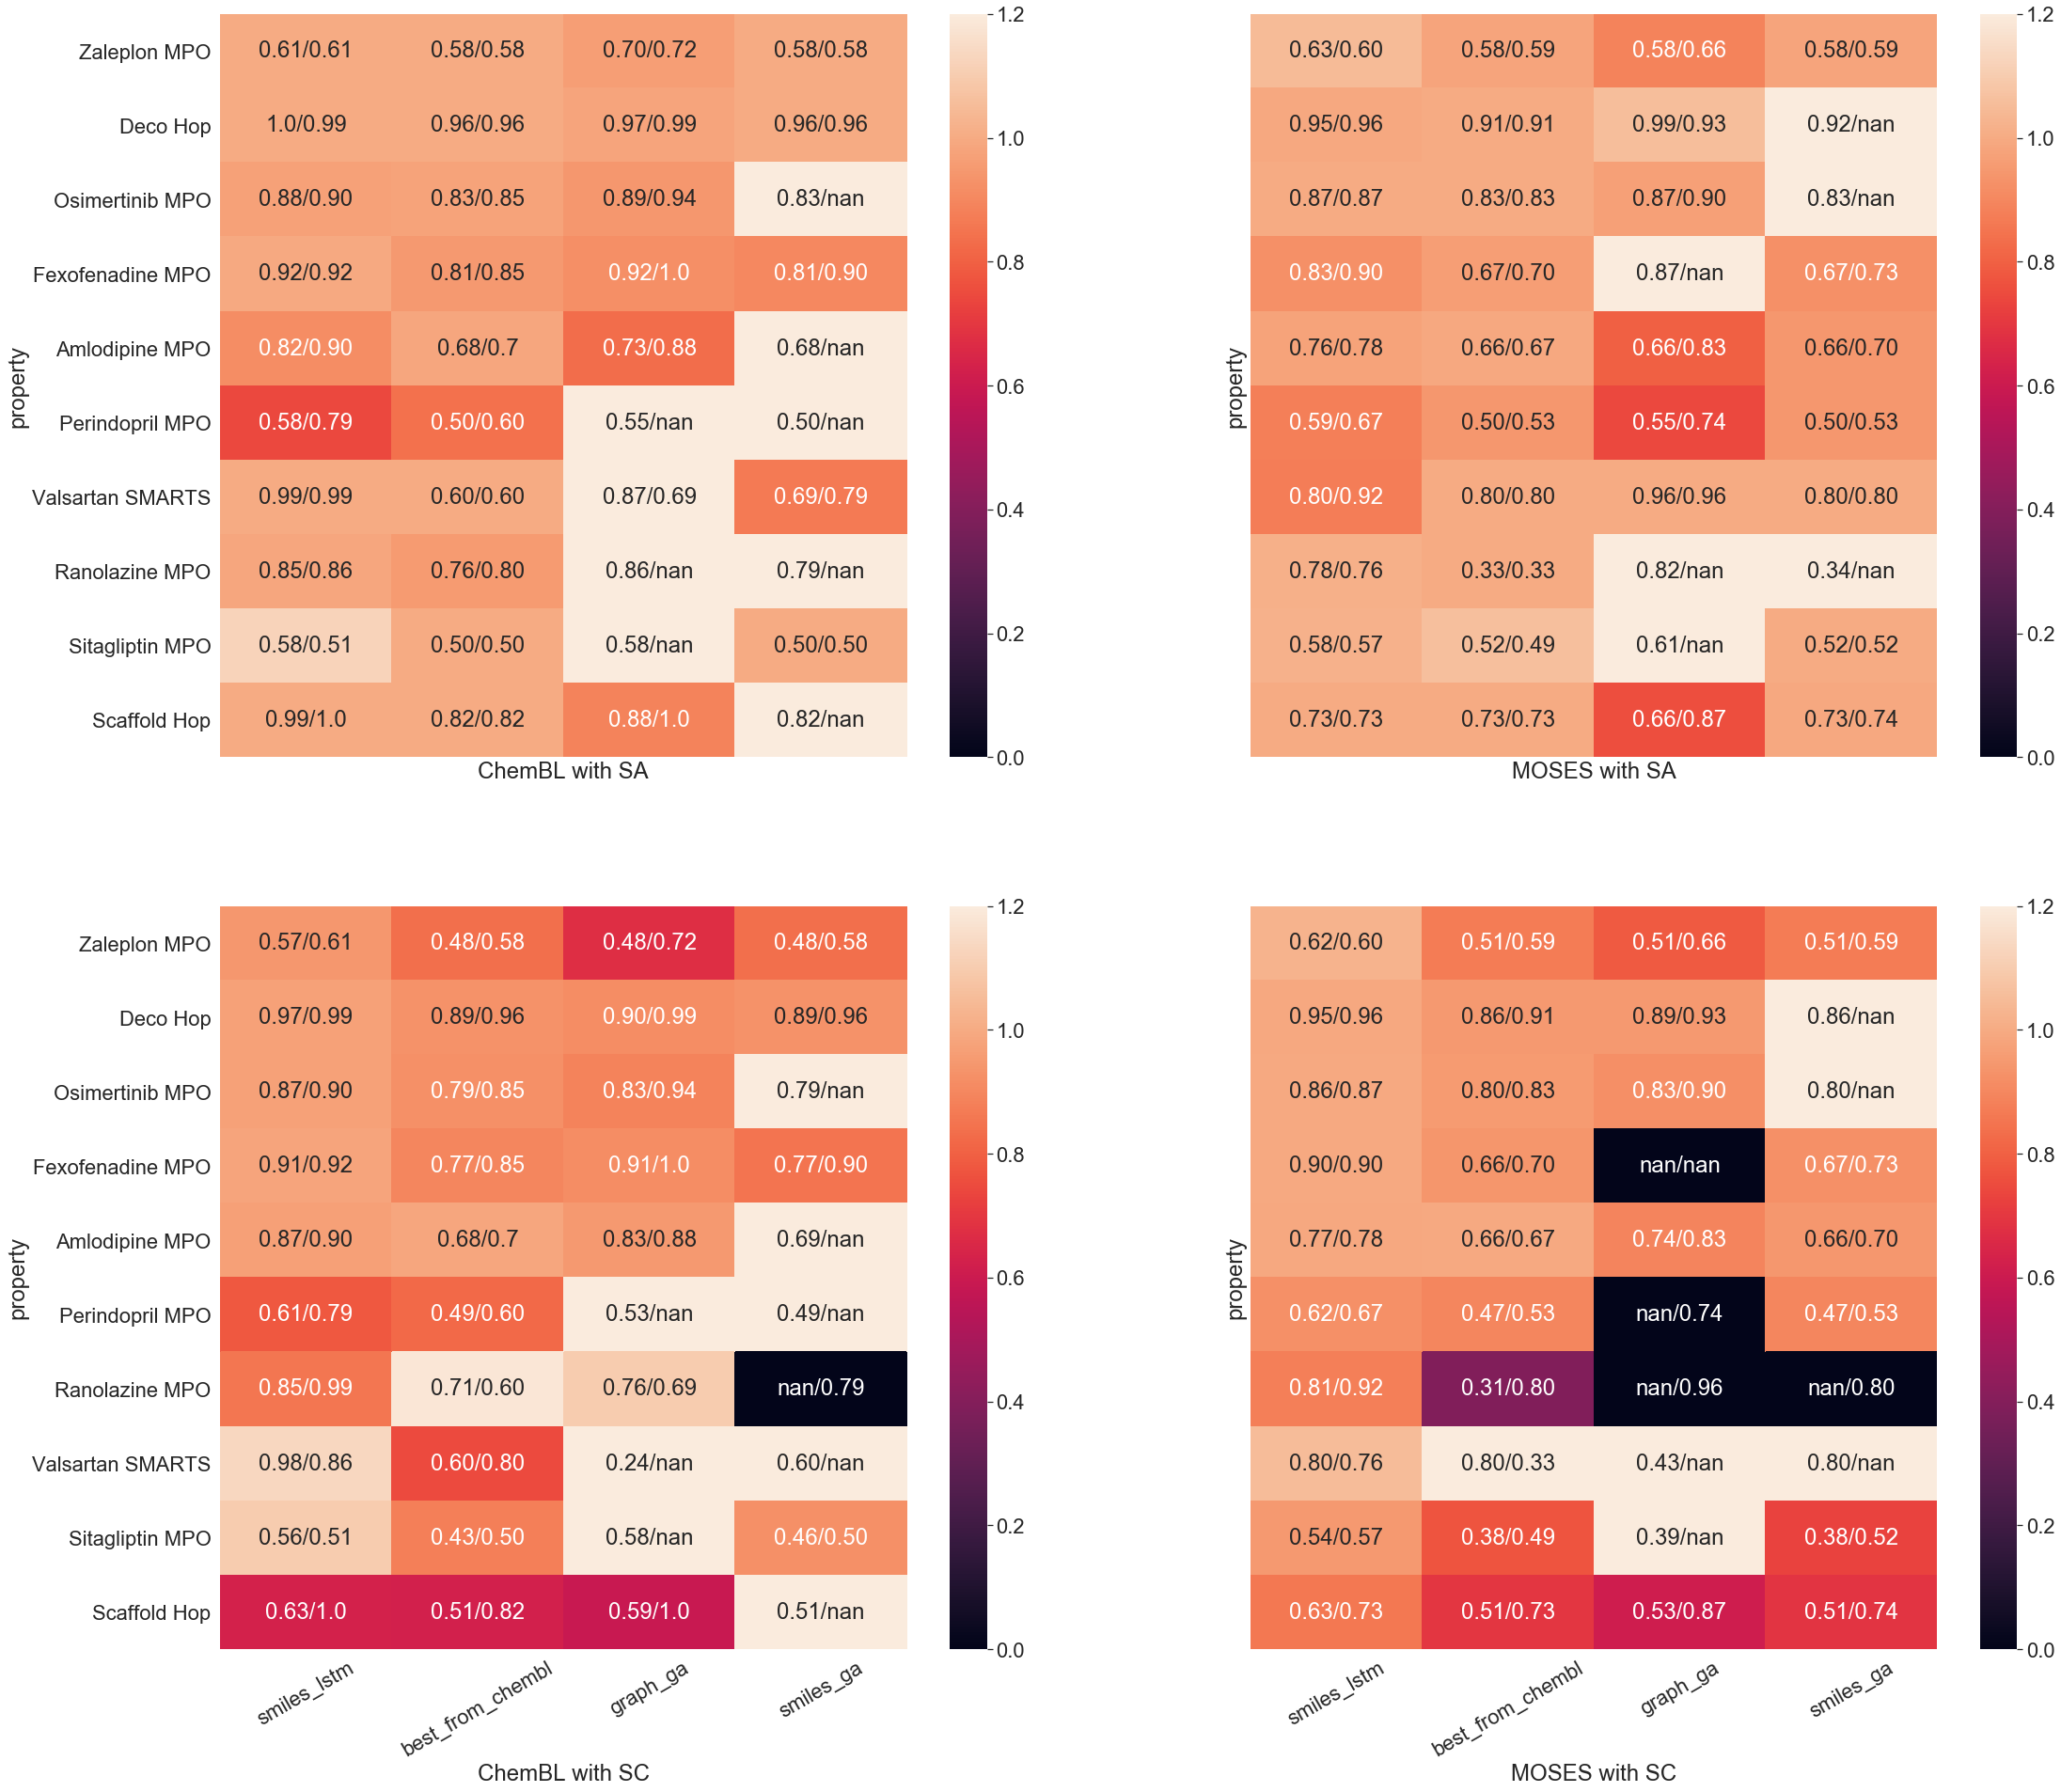

In [80]:
sns.set(font_scale=2)
fig = plt.figure(figsize=[36, 32])

df_goal_pivot = make_ratio(df_goal_hard_cwa_s1, df_goal_hard_cwo_s1, name='ChemBL with SA')
ax1 = plt.subplot(221)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_cwa_s1, df_goal_hard_cwo_s1),\
                 fmt='s', ax=ax1, vmin=0, vmax=1.2, xticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_hard_cwc_s1, df_goal_hard_cwo_s1, name='ChemBL with SC')
ax3 = plt.subplot(223)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_cwc_s1, df_goal_hard_cwo_s1),\
                 fmt='s', ax=ax3, vmin=0, vmax=1.2)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_hard_mwa_s1, df_goal_hard_mwo_s1, name='MOSES with SA')
ax2 = plt.subplot(222)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_mwa_s1, df_goal_hard_mwo_s1),\
                 fmt='s', ax=ax2, vmin=0, vmax=1.2, xticklabels=False, yticklabels=False)
plt.xticks(rotation=30)

df_goal_pivot = make_ratio(df_goal_hard_mwc_s1, df_goal_hard_mwo_s1, name='MOSES with SC')
ax4 = plt.subplot(224)
ax = sns.heatmap(df_goal_pivot, annot=make_annot(df_goal_hard_mwc_s1, df_goal_hard_mwo_s1),\
                 fmt='s', ax=ax4, vmin=0, vmax=1.2, yticklabels=False)
plt.xticks(rotation=30)


fig.savefig('./figure/goal_hard_objective_heatmap_s1.png')